In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf

from scipy import signal
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from math import sqrt


from bike_and_station_info import *
from time_series_model import *


## Load data, add features, subset, and define proposed locations

In [2]:
#load the data
data, weather = load_data()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
#add features to the dataset
data = feature_addition(data)

In [4]:
#subset the dataframe for desired city
city = model_city(data,1)

In [5]:
def subset_df(df, year, month, hist=3):
    #current month df
    cdf = df[(df.year == year) & (df.month == month)]
    #next month df
    ndf = df[(df.year == year) & (df.month == (month+1))]

    #create a new dataframe
    #which includes the current month's data
    #as well as data from previous months
    
    rollover = month-hist
    if rollover <0:
        lyear = year-1
        lmonth = 12+(rollover)+1
        dfu= df[(df.year == year)&(df.month <=month)]
        dfl= df[(df.year == lyear)&(df.month >=lmonth)]
        sub = dfu.append(dfl)
    else:
        sub = df[(df.year == year)&(df.month <=month) & (df.month>=month-hist)]


    
    #create a days column
    #this will be used to forecast as well as plotting
    sub['days'] = (sub.date) - sub.date.min()
    sub['days'] = sub['days'].dt.days

    return sub, cdf, ndf

In [6]:
sub, cdf, ndf = subset_df(city, 2019, 1)

In [7]:
sub.month.unique()

array([ 1, 11, 12])

In [8]:
sub

duration_sec              start_time                  end_time  \
1863722         65900 2019-01-31 20:58:33.886  2019-02-01 15:16:54.1730   
1863724         44680 2019-01-31 19:46:09.719  2019-02-01 08:10:50.3180   
1863725         60709 2019-01-31 14:19:01.541  2019-02-01 07:10:51.0650   
1863727          1188 2019-01-31 23:54:38.901  2019-02-01 00:14:27.9000   
1863729          3153 2019-01-31 23:17:05.462  2019-02-01 00:09:39.4570   
1863730           323 2019-01-31 23:59:47.568  2019-02-01 00:05:11.1770   
1863733           272 2019-01-31 23:59:44.880  2019-02-01 00:04:17.0800   
1863734           547 2019-01-31 23:51:54.232  2019-02-01 00:01:01.5050   
1863736           559 2019-01-31 23:51:17.407  2019-02-01 00:00:36.7480   
1863738           731 2019-01-31 23:46:39.438  2019-01-31 23:58:50.4940   
1863739           480 2019-01-31 23:48:58.583  2019-01-31 23:56:59.1980   
1863740           252 2019-01-31 23:52:29.407  2019-01-31 23:56:42.3240   
1863741           376 2019-01-31 23:49:32.777  2019-01-31 23:55:49.7280   
1863742           340 2019-01-31 23:49:27.061  2019-01-31 23:55:07.5000   
1863743          1485 2019-01-31 23:29:49.689  2019-01-31 23:54:35.1390   
1863745           851 2019-01-31 23:40:06.474  2019-01-31 23:54:17.9920   
1863746           836 2019-01-31 23:40:20.817  2019-01-31 23:54:16.9200   
1863747           480 2019-01-31 23:44:30.627  2019-01-31 23:52:31.5850   
1863748           538 2019-01-31 23:42:28.695  2019-01-31 23:51:27.5600   
1863749           342 2019-01-31 23:45:06.345  2019-01-31 23:50:48.6480   
1863751           473 2019-01-31 23:42:21.295  2019-01-31 23:50:14.8640   
1863752           193 2019-01-31 23:46:48.263  2019-01-31 23:50:02.1130   
1863753           478 2019-01-31 23:40:21.554  2019-01-31 23:48:20.0810   
1863754           748 2019-01-31 23:35:49.482  2019-01-31 23:48:18.4590   
1863755           129 2019-01-31 23:43:23.063  2019-01-31 23:45:32.5280   
1863757           563 2019-01-31 23:35:59.143  2019-01-31 23:45:23.0070   
1863759           335 2019-01-31 23:37:49.756  2019-01-31 23:43:25.2290   
1863761           588 2019-01-31 23:31:18.015  2019-01-31 23:41:06.2930   
1863762          1296 2019-01-31 23:19:26.634  2019-01-31 23:41:02.8290   
1863763          1304 2019-01-31 23:19:12.850  2019-01-31 23:40:57.4590   
...               ...                     ...                       ...   
1863678          1737 2018-12-01 00:37:01.374  2018-12-01 01:05:58.6410   
1863683           368 2018-12-01 00:57:09.877  2018-12-01 01:03:18.3310   
1863686           829 2018-12-01 00:47:07.983  2018-12-01 01:00:57.4960   
1863687          1195 2018-12-01 00:40:25.046  2018-12-01 01:00:21.0280   
1863688           182 2018-12-01 00:52:29.077  2018-12-01 00:55:32.0660   
1863689           332 2018-12-01 00:48:31.323  2018-12-01 00:54:04.2390   
1863690           331 2018-12-01 00:48:27.529  2018-12-01 00:53:59.4950   
1863692          1338 2018-12-01 00:27:24.875  2018-12-01 00:49:43.3490   
1863693           154 2018-12-01 00:44:24.838  2018-12-01 00:46:59.3350   
1863694           862 2018-12-01 00:32:11.063  2018-12-01 00:46:33.7900   
1863695          1310 2018-12-01 00:23:53.342  2018-12-01 00:45:43.5880   
1863697          2071 2018-12-01 00:09:55.580  2018-12-01 00:44:26.6290   
1863698          1958 2018-12-01 00:11:35.022  2018-12-01 00:44:13.6320   
1863699           268 2018-12-01 00:37:23.134  2018-12-01 00:41:51.9670   
1863702           293 2018-12-01 00:36:01.525  2018-12-01 00:40:55.2850   
1863703           426 2018-12-01 00:32:13.125  2018-12-01 00:39:19.8710   
1863704           447 2018-12-01 00:31:36.148  2018-12-01 00:39:03.3910   
1863705          1694 2018-12-01 00:09:17.159  2018-12-01 00:37:31.2400   
1863706           269 2018-12-01 00:31:00.091  2018-12-01 00:35:29.8710   
1863707           685 2018-12-01 00:21:16.240  2018-12-01 00:32:42.0000   
1863708           681 2018-12-01 00:19:41.383  2018-12-01 00:31:02.6050   
1863710           763 2018-12-01 0

In [9]:
#proposed stations
ps = new_stn_coords(cdf, ndf)
ps

[344.0, 386.0, 51.0, 398.0]

## Identify neighbor stations

In [10]:
def knn_proposed_stn(sub, df1, df2, proposed_stn, num_neighbors = 3):
    
    #all coordinates for each trip
    coordinates = np.array(df1[['start_station_longitude', 'start_station_latitude']])
    
    #unique coords in df1
    unique_coords = np.unique(coordinates, axis = 0)
    
    #current month
    cm = df1.month.unique()[0]
    
    #get the id and coords for current month
    id_coord_df1 = stn_coords(df1)
    id_coord_df2 = stn_coords(df2)
    
    knn_dict = {}
    
    #iterate through each proposed station
    for p in proposed_stn:
        
        #use euclidean_distance to find distances between each point
        dist = euclidean_distance(id_coord_df2.get(p), unique_coords)
        
        #sort the distances from closest to furthest
        potential_neighbors = unique_coords[np.argsort(dist)]
        
        neighbors = np.array([0,0])
        
        #in the list of potential neighbors, use neighbors with more than 30 days of trips
        for pot in potential_neighbors:
            
            #get the station id
            sid = sub.start_station_id[(sub.start_station_longitude==pot[0])\
                                       &(sub.start_station_latitude==pot[1])].unique()[0]
#             if len(cdf.days[cdf.start_station_id==sid].unique())>10:
            if len(sub.days[(sub.start_station_id==sid) \
                            & (sub.month == cm)].unique())>10:
                neighbors = np.vstack((neighbors, pot))
        neighbors = neighbors[1:num_neighbors+1]
        


    #         k = df.start_station_id[(df.start_station_longitude == id_coord_df2.get(p)[0]) &(df.start_station_latitude == id_coord_df2.get(p)[1])].iloc[0]
        #list for storing neighboring station ids
        neighbor_ids = []
        for i in range(num_neighbors):
            knn_id = sub.start_station_id[(sub.start_station_longitude == neighbors[i][0]) &(sub.start_station_latitude == neighbors[i][1])].iloc[0]
            neighbor_ids.append(int(knn_id))
        knn_dict[int(p)] = neighbor_ids
    return knn_dict, id_coord_df1, id_coord_df2

In [11]:
#neighbors for each proposed location
#id and coordinate combo for each station
neighbors, id_coord1, id_coord2 = knn_proposed_stn(sub, cdf, ndf, ps)

In [12]:
neighbors

{344: [345, 116, 115],
 386: [134, 133, 141],
 51: [377, 380, 375],
 398: [371, 369, 370]}

In [13]:
def plt_neighbors(cdf, neighbors, coords):
    for k, v in neighbors.items(): 
        print("The origin station is {}.".format(k))
        n1 = int(neighbors.get(k)[0])
        n2 = int(neighbors.get(k)[1])
        n3 = int(neighbors.get(k)[2])
        print("The 3 closest stations are: {}, {}, {}".format(n1,n2,n3))
        plt.figure(figsize = (10,10))
        
        
        #lims for SF
        ll,rr = -122.50, -122.36
        bb = 37.73
#         #lims for OAK
#         ll,rr = -122.33, -122.19
#         bb = 37.76
        plt.xlim(ll,rr)
        plt.ylim(bb, bb+(rr-ll))
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Map of Ford GoBike stations in San Francisco")
        plt.scatter(cdf.end_station_longitude, cdf.end_station_latitude, s=1, c=('r'))
        plt.scatter(coords.get(k)[0], coords.get(k)[1], s=50, marker='x', c=('b'))

        for st in neighbors.get(k):
            plt.scatter(coords.get(st)[0],coords.get(st)[1], s= 20, c='g')
        plt.show()



The origin station is 344.
The 3 closest stations are: 345, 116, 115


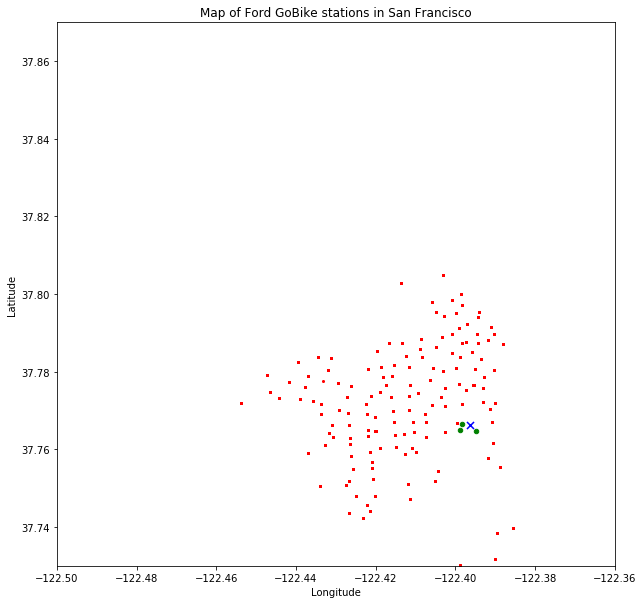

The origin station is 386.
The 3 closest stations are: 134, 133, 141


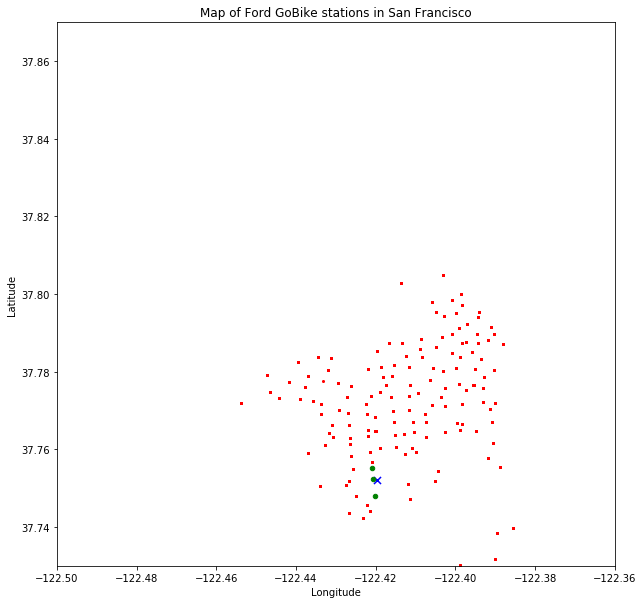

The origin station is 51.
The 3 closest stations are: 377, 380, 375


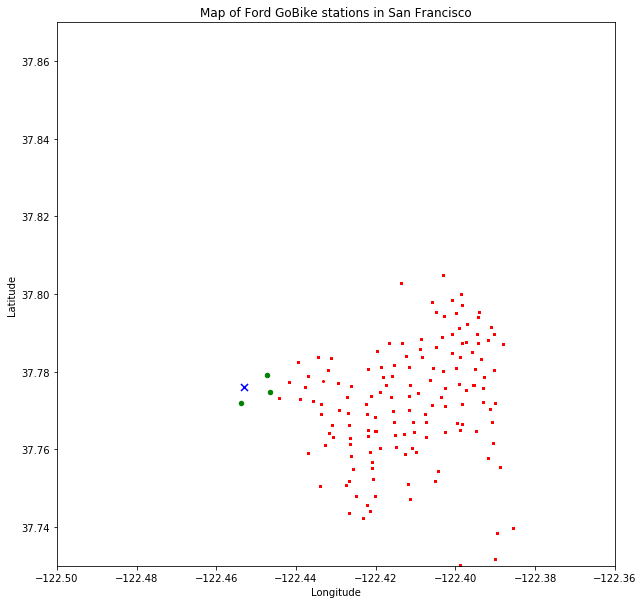

The origin station is 398.
The 3 closest stations are: 371, 369, 370


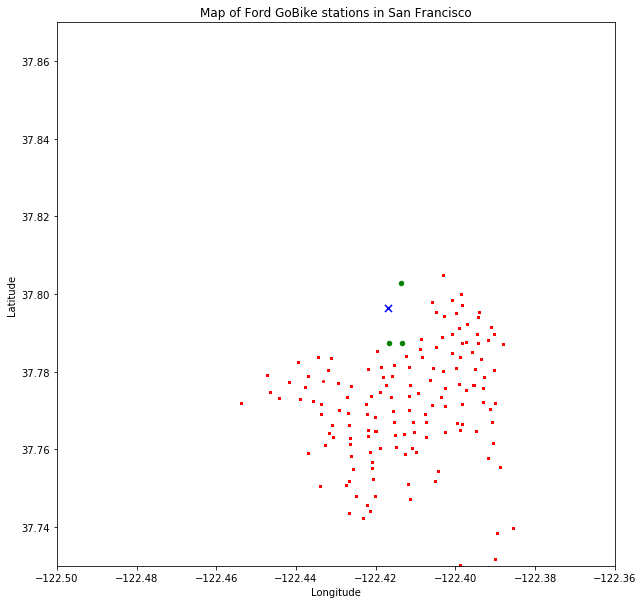

In [14]:
plt_neighbors(cdf, neighbors, id_coord2)

In [15]:
def plt_stn():
    row_sze = len(neighbors)
    col_sze = len(next(iter(neighbors.values())))
    rnge = row_sze*col_sze
    fig = plt.figure(figsize=(10,10))
    graph = 1
    for k, v in neighbors.items():
        num = 1
        for s_id in v:
            plt.subplot(rnge,1,graph)
            plt.subplots_adjust(top=10, bottom =5)
            plt.xlabel("days")
            plt.ylabel("trips per day")
            plt.title("This is station {}, and it is neighbor #{} for station {}".format(s_id, num, k))
            ts = trips_per_day(sub, s_id)
            plt.plot(ts[:,0],ts[:,1])
            num+=1
            graph+=1
            

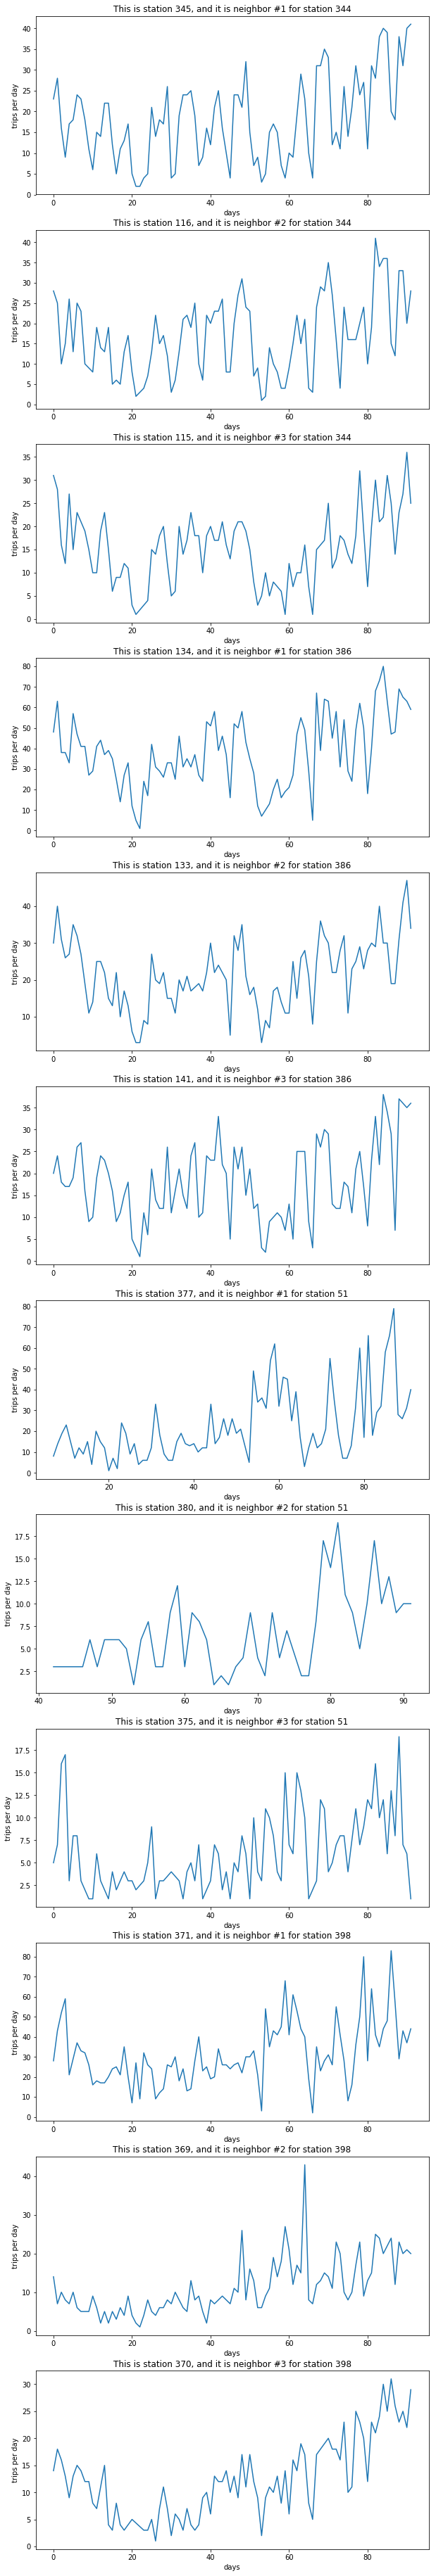

In [16]:
plt_stn()

## Testing Stations/Debugging

In [18]:
neighbors


{344: [345, 116, 115],
 386: [134, 133, 141],
 51: [377, 380, 375],
 398: [371, 369, 370]}

In [19]:
test_station=115

In [20]:
#array of trips per each day for test_station
ts = trips_per_day(sub, test_station)
ts

array([[ 0, 31],
       [ 1, 28],
       [ 2, 16],
       [ 3, 12],
       [ 4, 27],
       [ 5, 15],
       [ 6, 23],
       [ 7, 21],
       [ 8, 19],
       [ 9, 15],
       [10, 10],
       [11, 10],
       [12, 19],
       [13, 23],
       [14, 15],
       [15,  6],
       [16,  9],
       [17,  9],
       [18, 12],
       [19, 11],
       [20,  3],
       [21,  1],
       [23,  3],
       [24,  4],
       [25, 15],
       [26, 14],
       [27, 18],
       [28, 20],
       [29, 12],
       [30,  5],
       [31,  6],
       [32, 20],
       [33, 14],
       [34, 17],
       [35, 23],
       [36, 18],
       [37, 18],
       [38, 10],
       [39, 18],
       [40, 20],
       [41, 17],
       [42, 17],
       [43, 21],
       [44, 16],
       [45, 13],
       [46, 19],
       [47, 21],
       [48, 21],
       [49, 19],
       [50, 15],
       [51,  8],
       [52,  3],
       [53,  5],
       [54, 10],
       [55,  5],
       [56,  8],
       [57,  7],
       [58,  6],
       [59,  1

In [21]:
tseries = pd.Series(ts[:,1])

In [22]:
tseries.values

array([31, 28, 16, 12, 27, 15, 23, 21, 19, 15, 10, 10, 19, 23, 15,  6,  9,
        9, 12, 11,  3,  1,  3,  4, 15, 14, 18, 20, 12,  5,  6, 20, 14, 17,
       23, 18, 18, 10, 18, 20, 17, 17, 21, 16, 13, 19, 21, 21, 19, 15,  8,
        3,  5, 10,  5,  8,  7,  6,  1, 12,  7, 10, 10, 16,  7,  1, 15, 16,
       17, 25, 11, 13, 18, 17, 14, 12, 18, 32, 19,  7, 20, 30, 21, 22, 31,
       25, 14, 23, 27, 36, 25])

In [23]:
#test to see if the series is stationary
test = sm.tsa.stattools.adfuller(tseries)
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.07


In [24]:
tseries_diffed = tseries.diff()[1:]

In [25]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]

1.711577635527255e-14

In [26]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]<0.05

True

In [27]:
def stationary_convert(series, pvalue=0.05):
    test = sm.tsa.stattools.adfuller(series)
    if test[1] > pvalue:
        tseries_diffed = tseries.diff()[1:]
        return tseries_diffed
    return series

In [28]:
tseries_diff = stationary_convert(tseries)
sm.tsa.stattools.adfuller(tseries_diff)[1]<0.05

True

In [29]:
trip_vals = tseries.values
trip_vals

array([31, 28, 16, 12, 27, 15, 23, 21, 19, 15, 10, 10, 19, 23, 15,  6,  9,
        9, 12, 11,  3,  1,  3,  4, 15, 14, 18, 20, 12,  5,  6, 20, 14, 17,
       23, 18, 18, 10, 18, 20, 17, 17, 21, 16, 13, 19, 21, 21, 19, 15,  8,
        3,  5, 10,  5,  8,  7,  6,  1, 12,  7, 10, 10, 16,  7,  1, 15, 16,
       17, 25, 11, 13, 18, 17, 14, 12, 18, 32, 19,  7, 20, 30, 21, 22, 31,
       25, 14, 23, 27, 36, 25])

In [30]:
trip_model = ARIMA(trip_vals, order=(3, 1, 0)).fit()

In [31]:
predictions = trip_model.predict(75, 85, typ='levels')
predictions

array([14.49345573, 14.34180692, 17.574635  , 24.89811541, 15.63931238,
       14.30440067, 23.97405676, 23.05235895, 16.70186861, 23.8494072 ,
       29.39813894])

In [32]:
test = np.append(trip_vals, predictions)

In [33]:
test1 = pd.Series(test)

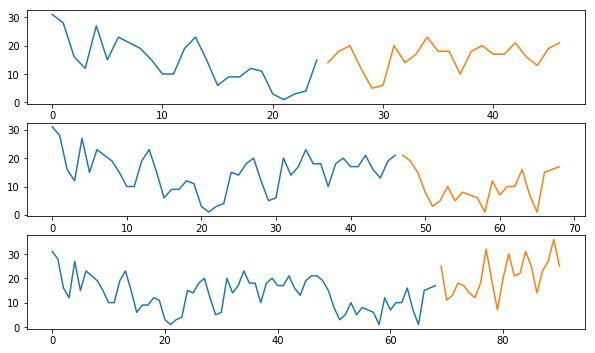

In [34]:
tseries = pd.Series(ts[:,1])
tscv = TimeSeriesSplit(n_splits=3)
fig = plt.figure(figsize=(10,10))
index = 1
for train_index, test_index in tscv.split(tseries):
    train = tseries[train_index]
    test = tseries[test_index]
    plt.subplot(5,1,index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()

In [35]:
def ARIMA_pred(arr, p=1, d=1, q=1):
    
    tseries = pd.Series(arr[:,1])
#     tseries = stationary_convert(tseries)
    tscv = TimeSeriesSplit(n_splits=3)
    fig = plt.figure(figsize=(10,10))
    index = 1
    
    actual = []
    mean_rmse= np.array([])
    for train_index, test_index in tscv.split(tseries):
        train = tseries[train_index]
        test = tseries[test_index]

        train_vals = train.values
#         trip_model = ARIMA(train_vals, order=(p, d, q)).fit()
        try:
            trip_model = ARIMA(train_vals, order=(p, d, q)).fit()
        except:
            print("there was an exception with parameters {},{},{}".format(p,d,q))
        train_sze = len(train)
        predictions = trip_model.predict(train_sze, train_sze+len(test)-1, typ='levels')
        
        #calculate mean squared error
        mse = mean_squared_error(predictions, np.array(test))
        rmse = mse.mean()
        mean_rmse = np.append(mean_rmse, rmse)
        
        #combine to plot on same graph
        combined = np.append(train_vals, predictions)
        combined = pd.Series(combined)
        plt.subplot(3,1,index)
        plt.xlabel('Days')
        plt.ylabel('Trip Counts')
        plt.title('This has a mean squared error of {}'.format(mse))
        plt.plot(combined.index[:train_sze], combined[:train_sze], label="train")
        plt.plot(combined.index[train_sze:], combined[train_sze:], label='predicted')


        index +=1
    avg_rmse = mean_rmse.mean()
    return avg_rmse

In [36]:
sqrt(123)

11.090536506409418

In [37]:
#test to see if the series is stationary
test = sm.tsa.stattools.adfuller(ts[:,1])
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.07


In [38]:
def best_ARIMA_param(arr):
    max_param = 3
    score = np.array([0,0,0,0])
    exceptions = 0
    for p in range(1,max_param+1):
        for d in range(1,max_param+1):
            for q in range(1,max_param+1):
                try:
                    rmse = ARIMA_pred(arr, p, d, q)
                    score_data = np.array([p,d,q,rmse])
                    score = np.vstack((score, score_data))
                except: 
                    print("The hyper parameters {}, {}, and {} did not work.".format(p, d, q))
                    exceptions +=1
    print ("There were a total of {} exceptions.".format(exceptions/max_param**3))
    return score[1:]

there was an exception with parameters 1,1,1
The hyper parameters 1, 1, and 1 did not work.
there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:666: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or 

The hyper parameters 2, 2, and 2 did not work.
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:666: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or 

The hyper parameters 3, 1, and 2 did not work.
there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.
there was an exception with parameters 3,2,1
The hyper parameters 3, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8888888888888888 exceptions.


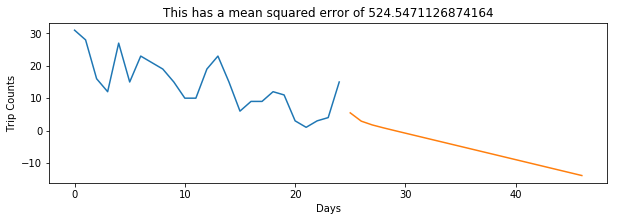

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

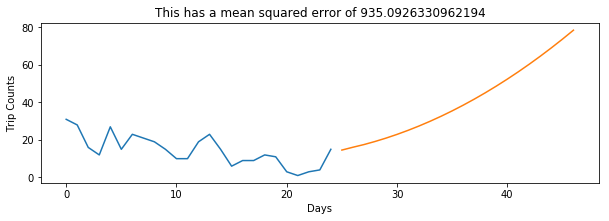

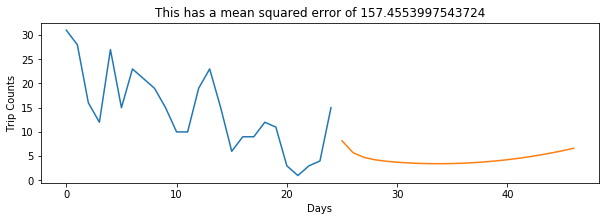

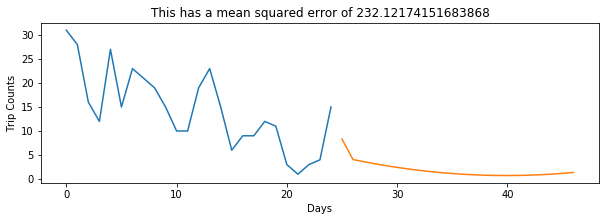

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

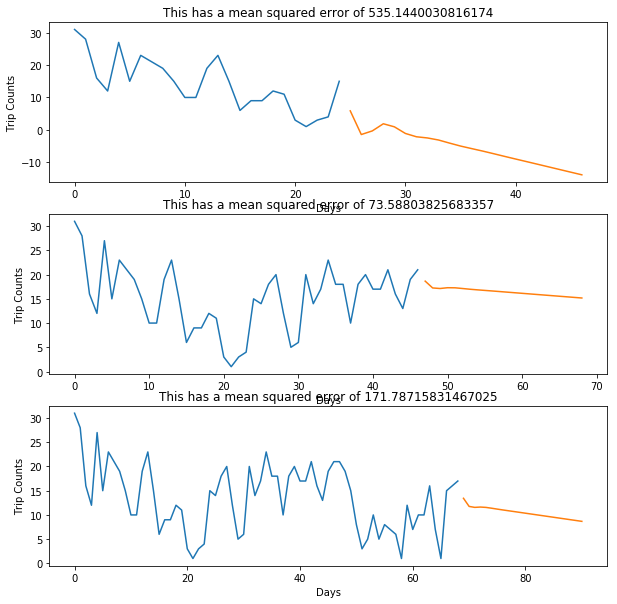

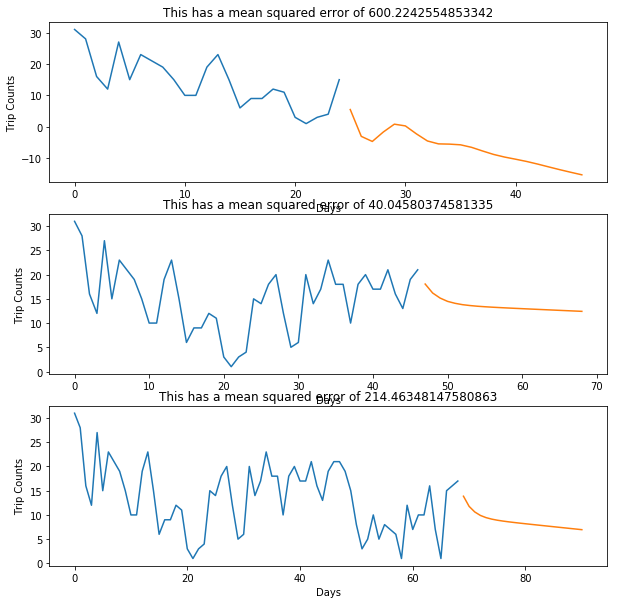

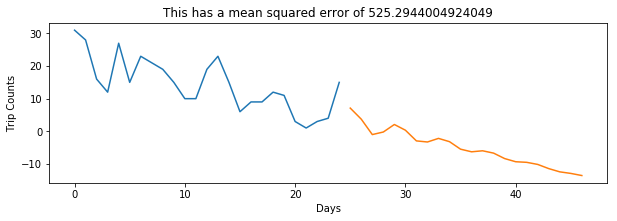

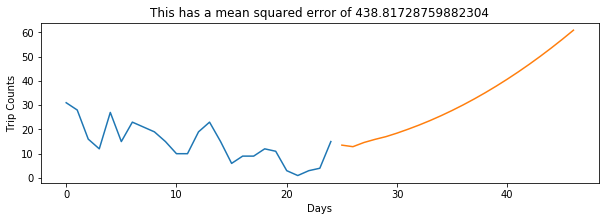

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

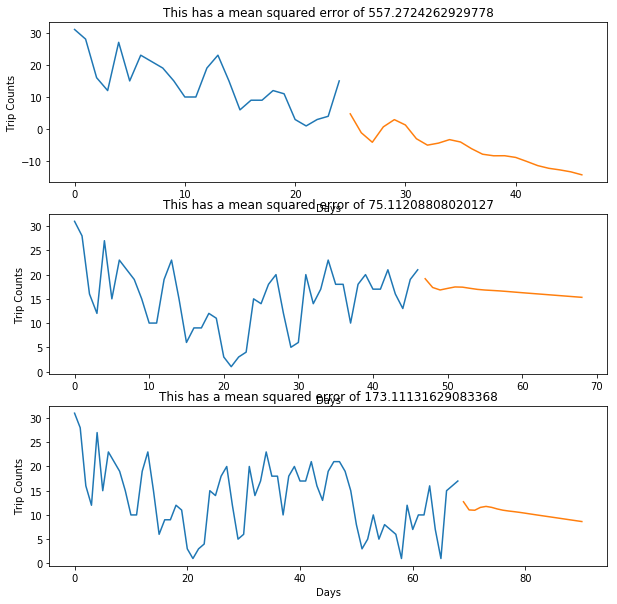

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

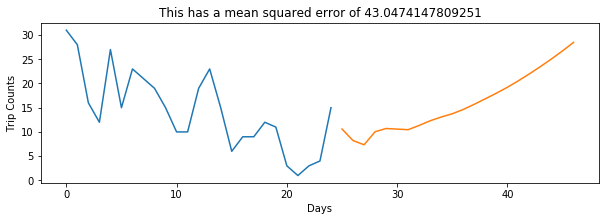

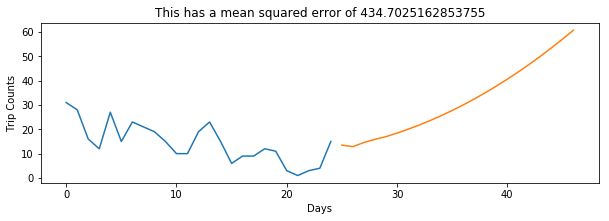

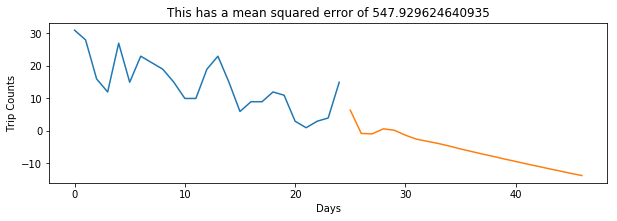

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [39]:
score = best_ARIMA_param(ts)

In [40]:
score

array([[  2.        ,   1.        ,   1.        , 260.17306655],
       [  2.        ,   1.        ,   2.        , 284.91118024],
       [  3.        ,   1.        ,   1.        , 268.49861022]])

In [41]:
np.sort(score[:,3]).reshape(-1,1)

array([[260.17306655],
       [268.49861022],
       [284.91118024]])

In [42]:
np.sort(score[:,3]).reshape(-1,1)[0]

array([260.17306655])

In [43]:
score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]

array([ True, False, False])

In [44]:
score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]

array([[  2.        ,   1.        ,   1.        , 260.17306655]])

In [45]:
score

array([[  2.        ,   1.        ,   1.        , 260.17306655],
       [  2.        ,   1.        ,   2.        , 284.91118024],
       [  3.        ,   1.        ,   1.        , 268.49861022]])

In [46]:
def best_params(score):
    best_params = score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]
    return best_params

In [47]:
b_params = best_params(score)

In [48]:
def forecast_nxt_30d(ts, b_params, months=3):
    tseries = pd.Series(ts[:,1])
    p = int(b_params[0][0])
    d = int(b_params[0][1])
    q = int(b_params[0][2])
    
    current_vals = tseries.values
    model = ARIMA(current_vals, order=(p, d, q)).fit()

    train_sze = len(current_vals)
#     predictions = trip_model.predict(train_sze, train_sze+30, typ='levels')
    predictions = model.predict((30*months), (30*months)+3, typ='levels')

    #combine to plot on same graph
    combined = np.append(current_vals, predictions)
    combined = pd.Series(combined)
    plt.xlabel('Days')
    plt.ylabel('Trip Counts')
#     plt.title('This has a mean squared error of {}'.format(mse))
    plt.plot(combined.index[:train_sze], combined[:train_sze], label="train")
    plt.plot(combined.index[train_sze:], combined[train_sze:], label='predicted')
    
    next_month_avg_pred = np.round(predictions.mean(), decimals=2)
    return next_month_avg_pred

In [49]:
tseries = pd.Series(ts[:,1])
current_vals= tseries.values
current_vals

array([31, 28, 16, 12, 27, 15, 23, 21, 19, 15, 10, 10, 19, 23, 15,  6,  9,
        9, 12, 11,  3,  1,  3,  4, 15, 14, 18, 20, 12,  5,  6, 20, 14, 17,
       23, 18, 18, 10, 18, 20, 17, 17, 21, 16, 13, 19, 21, 21, 19, 15,  8,
        3,  5, 10,  5,  8,  7,  6,  1, 12,  7, 10, 10, 16,  7,  1, 15, 16,
       17, 25, 11, 13, 18, 17, 14, 12, 18, 32, 19,  7, 20, 30, 21, 22, 31,
       25, 14, 23, 27, 36, 25])

26.07

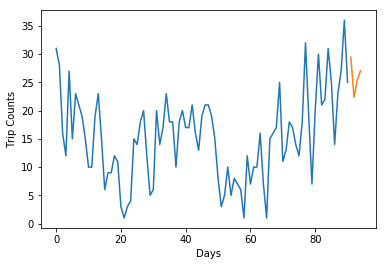

In [50]:
forecast_nxt_30d(ts, b_params)

In [51]:
tseries = pd.Series(ts[:,1])
current_vals = tseries.values
model = ARIMA(current_vals, order=(1, 1, 1)).fit()

In [52]:
ndf.head(2)

duration_sec              start_time                  end_time  \
2055803         52185 2019-02-28 17:32:10.145  2019-03-01 08:01:55.9750   
2055804         42521 2019-02-28 18:53:21.789  2019-03-01 06:42:03.0560   

         start_station_id                                start_station_name  \
2055803              21.0  Montgomery St BART Station (Market St at 2nd St)   
2055804              23.0                     The Embarcadero at Steuart St   

         start_station_latitude  start_station_longitude  end_station_id  \
2055803               37.789625              -122.400811            13.0   
2055804               37.791464              -122.391034            81.0   

                       end_station_name  end_station_latitude  ...  \
2055803  Commercial St at Montgomery St             37.794231  ...   
2055804              Berry St at 4th St             37.775880  ...   

         member_gender  bike_share_for_all_trip day_of_week        date  year  \
2055803           Male                       No           3  2019-02-28  2019   
2055804            NaN                       No           3  2019-02-28  2019   

        month  day hour  malfunction   age  
2055803     2   28   17        False  35.0  
2055804     2   28   18        False   NaN  

[2 rows x 24 columns]

In [53]:
val_df = ndf[ndf.end_station_id == test_station]
count = val_df.day.value_counts()
actual_trips_per_day = np.array(count).mean()

In [54]:
actual_trips_per_day

23.035714285714285

In [55]:
neighbors

{344: [345, 116, 115],
 386: [134, 133, 141],
 51: [377, 380, 375],
 398: [371, 369, 370]}

## apply predictions to neighbor statoins

In [61]:
def ready_set_go(sub,cdf,neighbors):
    #stores the proposed location's stations id and its neighbors' overall average trip count per day
    trend = {}
    #get the orgin station and its neighbor
    for k, v in neighbors.items():
        
        avg_temp = []
        #access each neighbor for station k
        for s in v:
            try:
                print ("This is station {}, and the neighbor is {}".format(k,s))

                #time series data for station s
                ts = trips_per_day(sub,s)

                #scores for each ARIMA hyper parameter combination
                score = best_ARIMA_param(ts)

                #best hyper parameter for the model
                #based on smallest MSE
                b_params = best_params(score)

                #average prediction of trips per day for the next month
                avg_pred = forecast_nxt_30d(ts, b_params)
                avg_temp.append(avg_pred)
            except:
                print ("Combination did not work")
        neigh_avg = np.round(np.array(avg_temp), decimal=3)
        trend[k] = neigh_avg
    return trend

This is station 344, and the neighbor is 345
there was an exception with parameters 1,1,1
The hyper parameters 1, 1, and 1 did not work.
there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.
there was an exception with parameters 2,1,1
The hyper parameters 2, 1, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
there was an exception with parameters 2,2,2
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:620: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:622: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.
there was an exception with parameters 3,2,1
The hyper parameters 3, 2, and 1 did not work.
there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.
there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8888888888888888 exceptions.
This is station 344, and the neighbor is 116


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 2,1,2
The hyper parameters 2, 1, and 2 did not work.
there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
there was an exception with parameters 2,2,2
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,1,2
The hyper parameters 3, 1, and 2 did not work.
there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.
there was an exception with parameters 3,2,1
The hyper parameters 3, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume

there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8888888888888888 exceptions.
This is station 344, and the neighbor is 115
there was an exception with parameters 1,1,1
The hyper parameters 1, 1, and 1 did not work.
there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487

there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
The hyper parameters 2, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWar

The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:666: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: R

The hyper parameters 3, 1, and 2 did not work.
there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.
there was an exception with parameters 3,2,1
The hyper parameters 3, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8888888888888888 exceptions.
This is station 386, and the neighbor is 134
there was an exception with parameters 1,1,1
The hyper parameters 1, 1, and 1 did not work.
there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa

there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.
there was an exception with parameters 2,1,1
The hyper parameters 2, 1, and 1 did not work.
there was an exception with parameters 2,1,2
The hyper parameters 2, 1, and 2 did not work.
there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with param

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:620: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:622: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.
there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8518518518518519 exceptions.
This is station 386, and the neighbor is 133
there was an exception with parameters 1,1,1
The hyper parameters 1, 1, and 1 did not work.
there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 2,1,2
The hyper parameters 2, 1, and 2 did not work.
there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
there was an exception with parameters 2,2,2
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWar

The hyper parameters 3, 1, and 2 did not work.
there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:666: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: R

The hyper parameters 3, 2, and 2 did not work.
there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8518518518518519 exceptions.
This is station 386, and the neighbor is 141


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507

there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
there was an exception with parameters 2,2,2
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,1,2
The hyper parameters 3, 1, and 2 did not work.
there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.
there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8148148148148148 exceptions.
This is station 51, and the neighbor is 377


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

there was an exception with parameters 2,1,2
The hyper parameters 2, 1, and 2 did not work.
there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 2,2,2
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume

there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.
there was an exception with parameters 3,2,1
The hyper parameters 3, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 3, 2, and 2 did not work.
there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8518518518518519 exceptions.
This is station 51, and the neighbor is 380
there was an exception with parameters 1,1,1
The hyper parameters 1, 1, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 2,1,2
The hyper parameters 2, 1, and 2 did not work.
there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
there was an exception with parameters 2,2,2
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,1,2
The hyper parameters 3, 1, and 2 did not work.
there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.
there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8888888888888888 exceptions.
This is station 51, and the neighbor is 375
there was an exception with parameters 1,1,1
The hyper parameters 1, 1, and 1 did not work.
there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
there was an exception with parameters 2,2,2
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/stat

there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.
there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.7777777777777778 exceptions.
This is station 398, and the neighbor is 371


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487

The hyper parameters 1, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: Run

there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pypl

there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matp

there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:620: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:622: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


there was an exception with parameters 3,2,2
The hyper parameters 3, 2, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.6296296296296297 exceptions.
This is station 398, and the neighbor is 369


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The hyper parameters 1, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: Run

there was an exception with parameters 2,1,3
The hyper parameters 2, 1, and 3 did not work.
there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 2,2,2
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:666: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: R

The hyper parameters 3, 1, and 2 did not work.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 f

The hyper parameters 3, 2, and 2 did not work.
there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.8148148148148148 exceptions.
This is station 398, and the neighbor is 370


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


there was an exception with parameters 1,1,2
The hyper parameters 1, 1, and 2 did not work.
there was an exception with parameters 1,1,3
The hyper parameters 1, 1, and 3 did not work.
there was an exception with parameters 1,2,1
The hyper parameters 1, 2, and 1 did not work.
there was an exception with parameters 1,2,2
The hyper parameters 1, 2, and 2 did not work.
there was an exception with parameters 1,2,3
The hyper parameters 1, 2, and 3 did not work.
there was an exception with parameters 1,3,1
The hyper parameters 1, 3, and 1 did not work.
there was an exception with parameters 1,3,2
The hyper parameters 1, 3, and 2 did not work.
there was an exception with parameters 1,3,3
The hyper parameters 1, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: Run

there was an exception with parameters 2,2,1
The hyper parameters 2, 2, and 1 did not work.
The hyper parameters 2, 2, and 2 did not work.
there was an exception with parameters 2,2,3
The hyper parameters 2, 2, and 3 did not work.
there was an exception with parameters 2,3,1
The hyper parameters 2, 3, and 1 did not work.
there was an exception with parameters 2,3,2
The hyper parameters 2, 3, and 2 did not work.
there was an exception with parameters 2,3,3
The hyper parameters 2, 3, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:692: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:665: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:666: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: R

there was an exception with parameters 3,1,3
The hyper parameters 3, 1, and 3 did not work.


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:507: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:487: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/matp

there was an exception with parameters 3,2,3
The hyper parameters 3, 2, and 3 did not work.
there was an exception with parameters 3,3,1
The hyper parameters 3, 3, and 1 did not work.
there was an exception with parameters 3,3,2
The hyper parameters 3, 3, and 2 did not work.
there was an exception with parameters 3,3,3
The hyper parameters 3, 3, and 3 did not work.
There were a total of 0.7037037037037037 exceptions.
Combination did not work


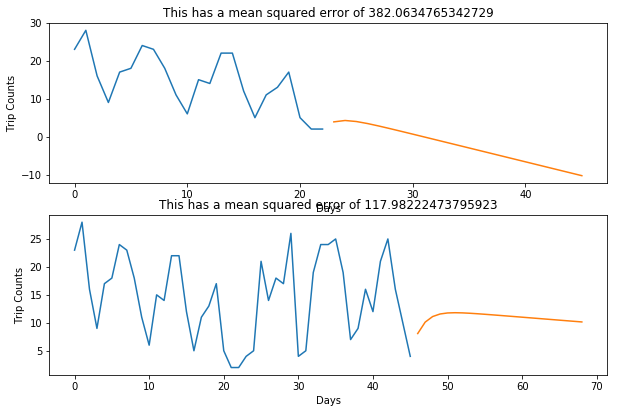

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

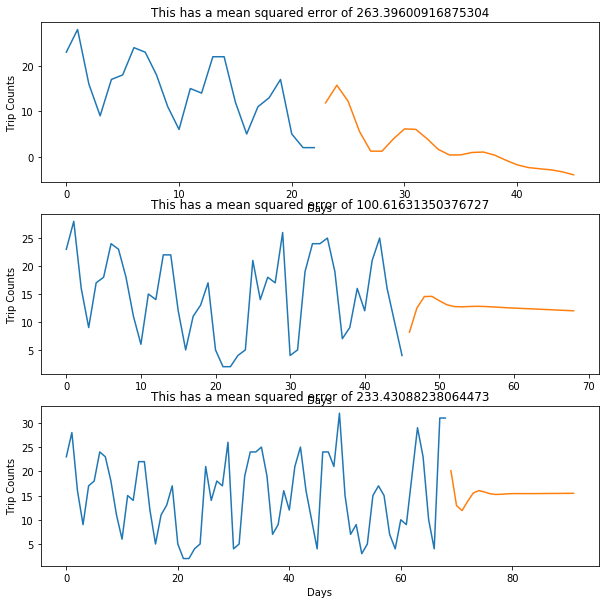

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

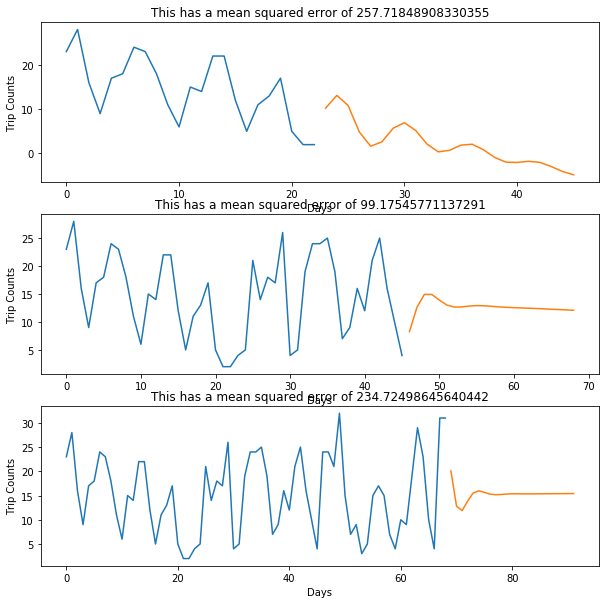

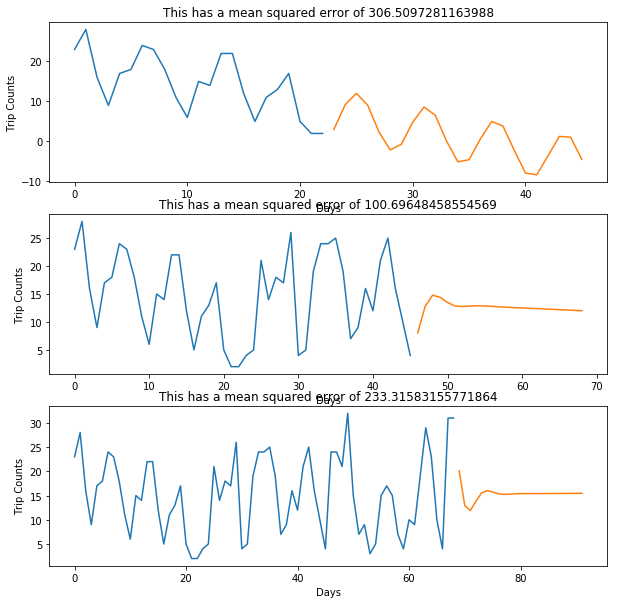

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

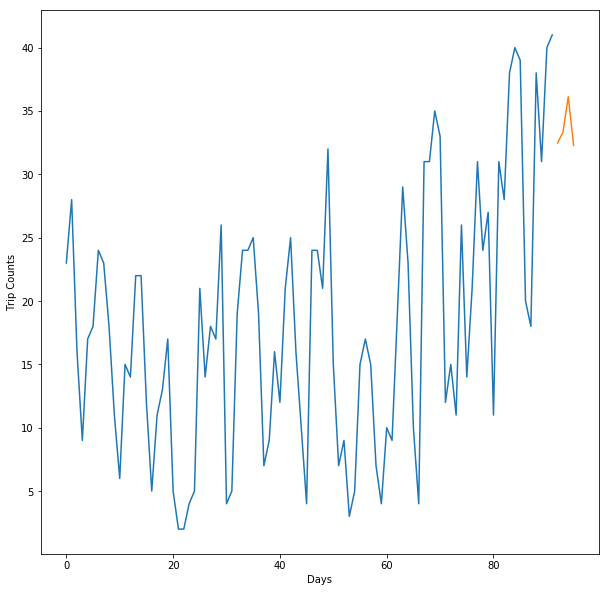

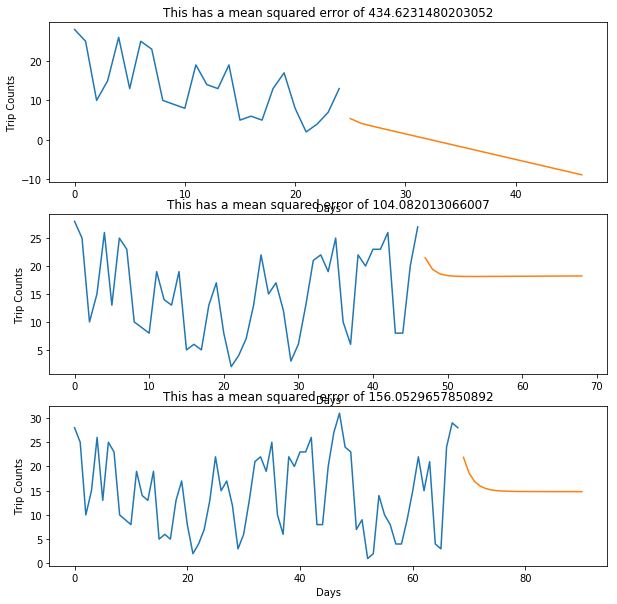

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

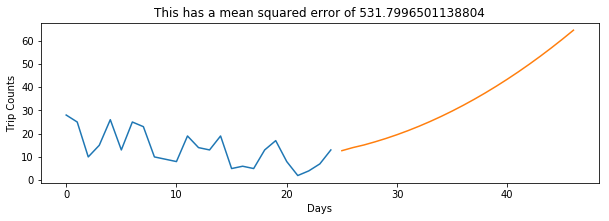

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

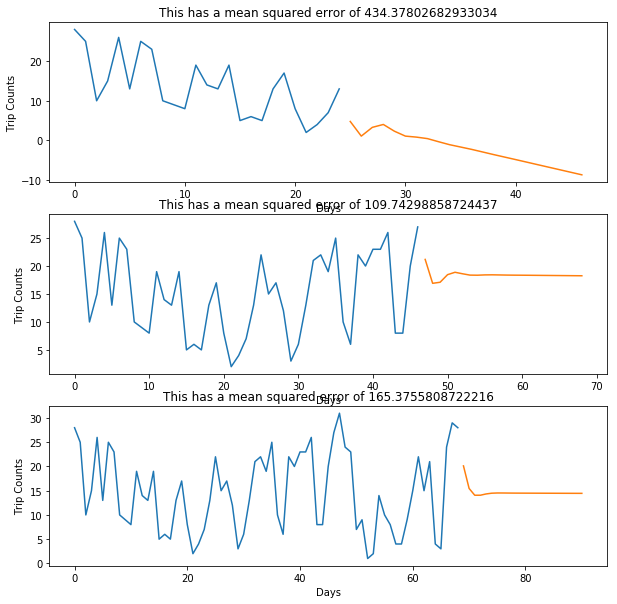

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

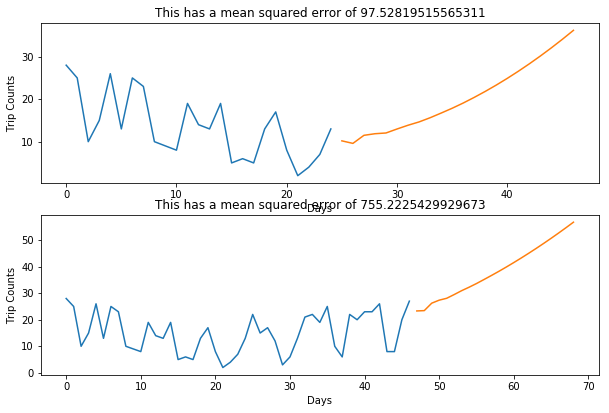

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

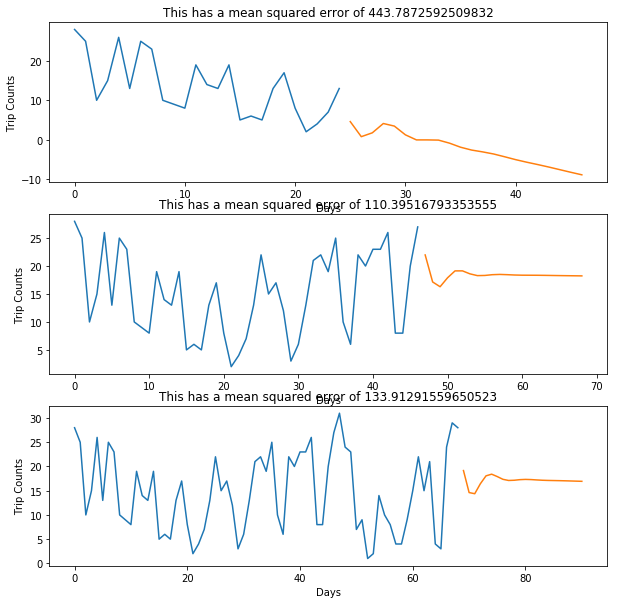

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

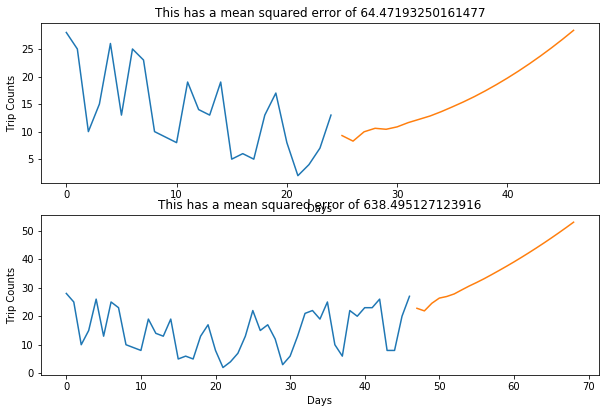

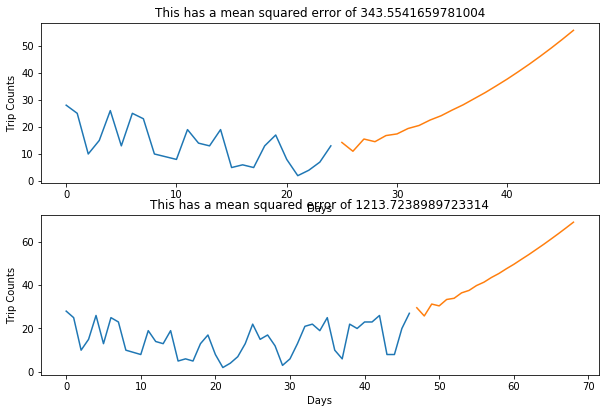

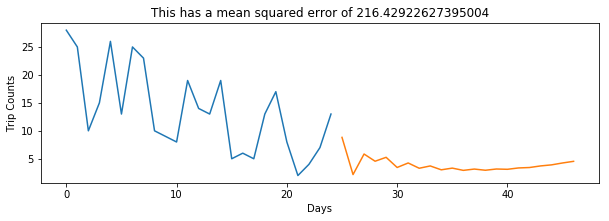

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

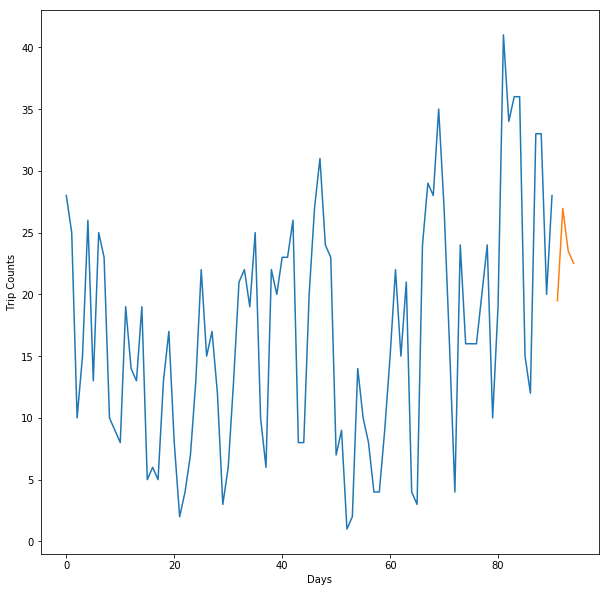

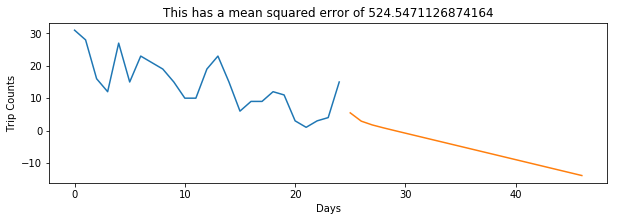

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

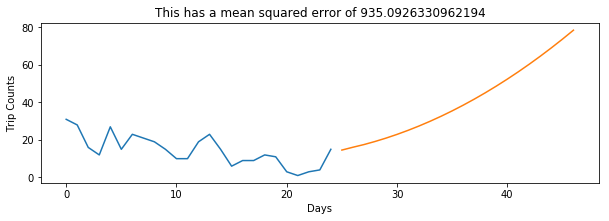

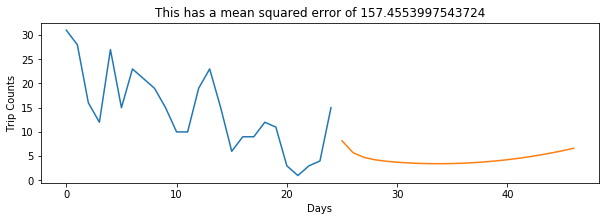

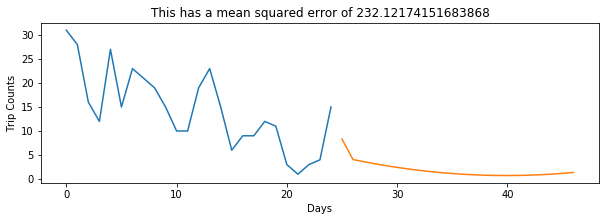

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

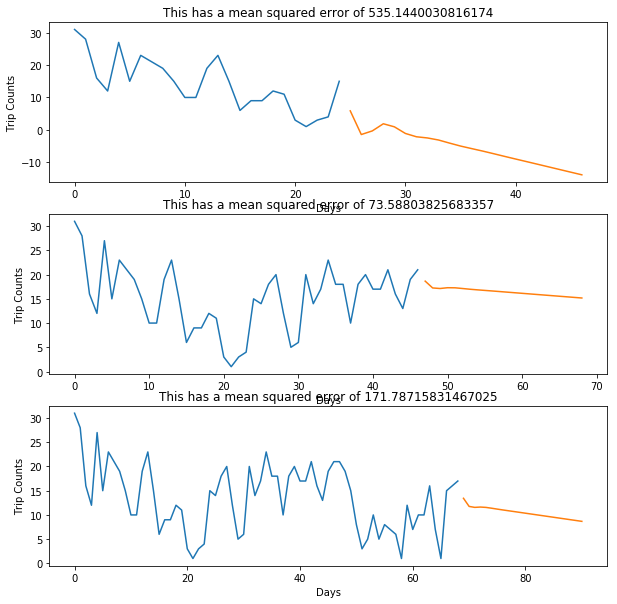

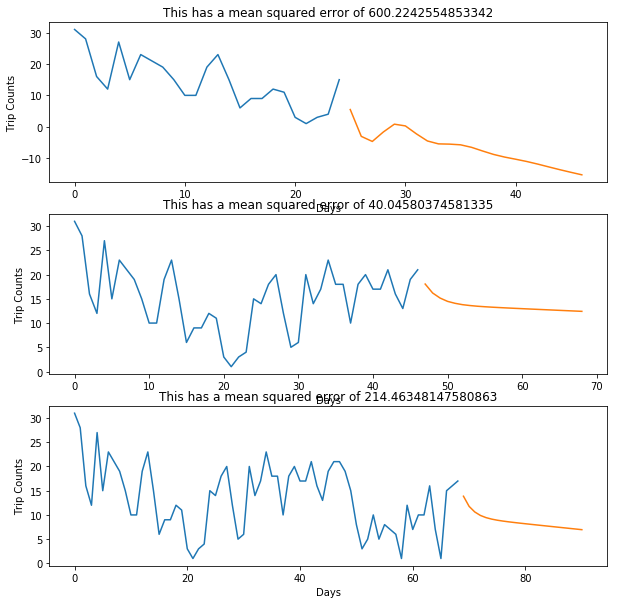

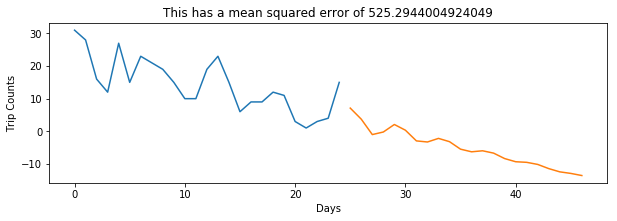

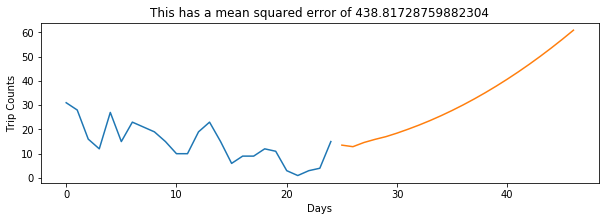

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

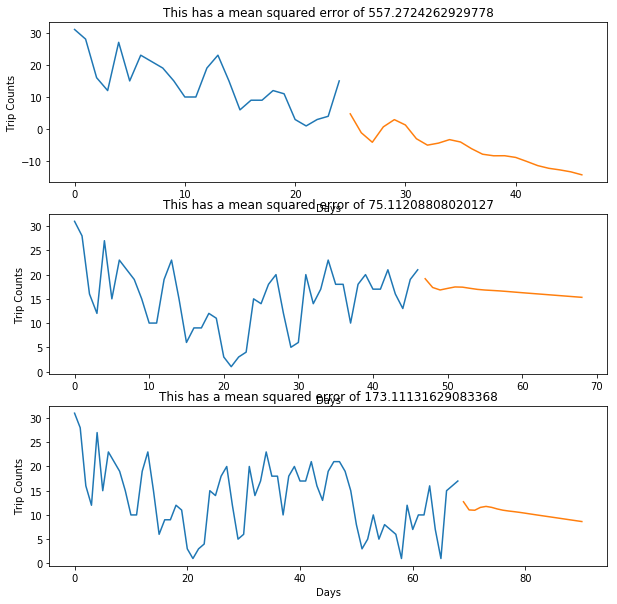

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

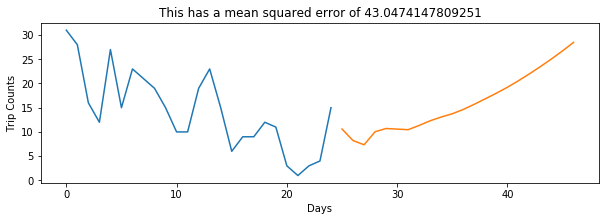

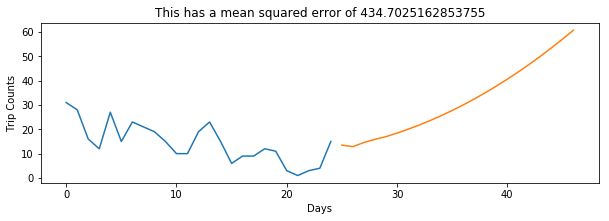

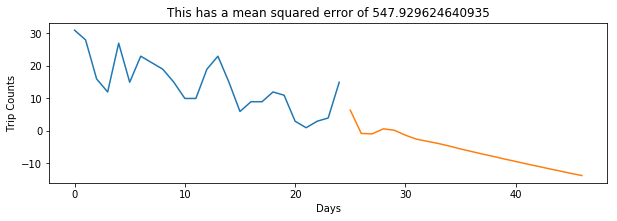

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

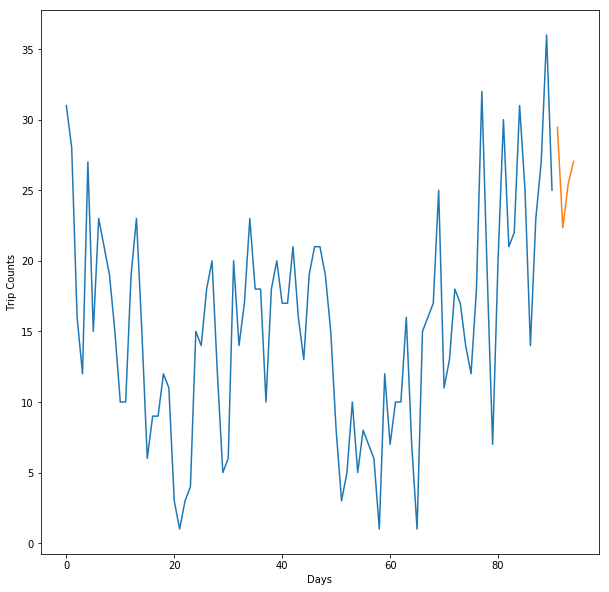

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

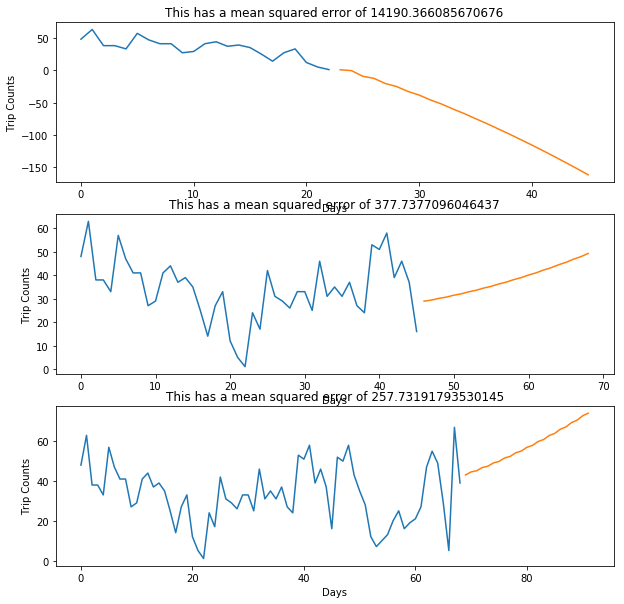

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

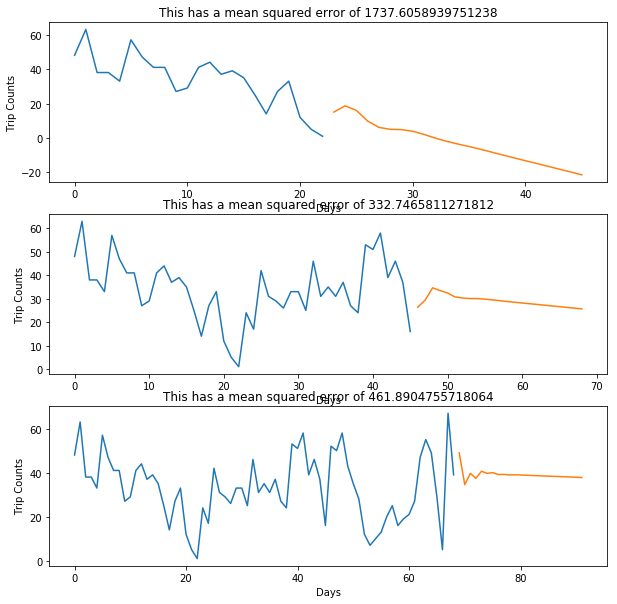

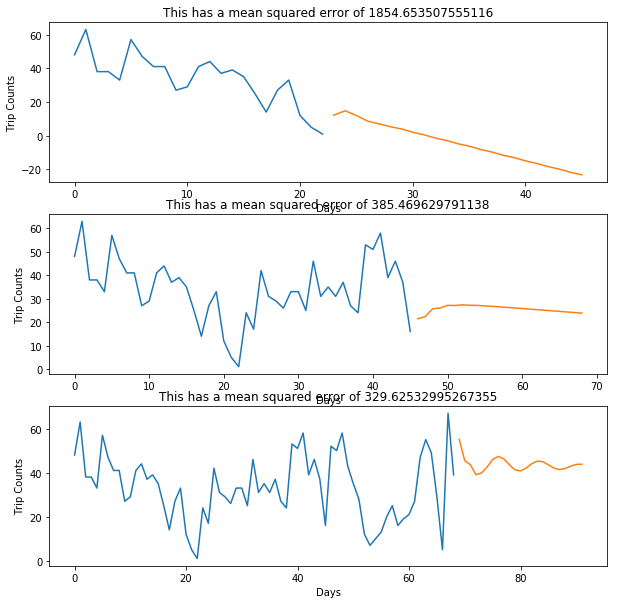

<Figure size 720x720 with 0 Axes>

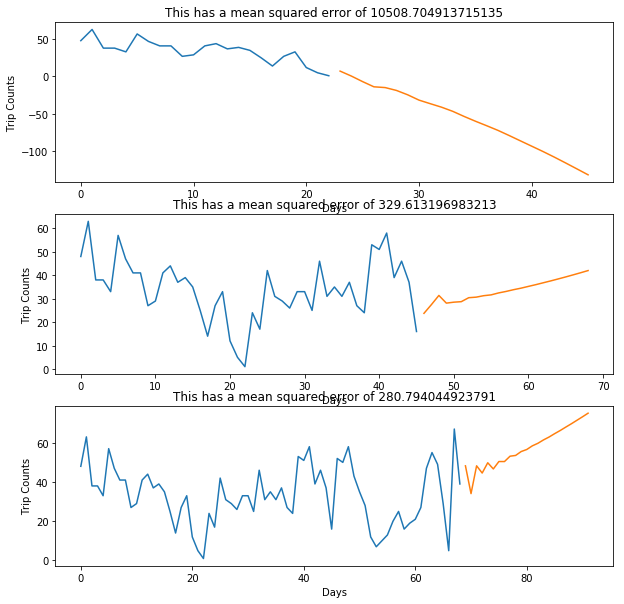

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

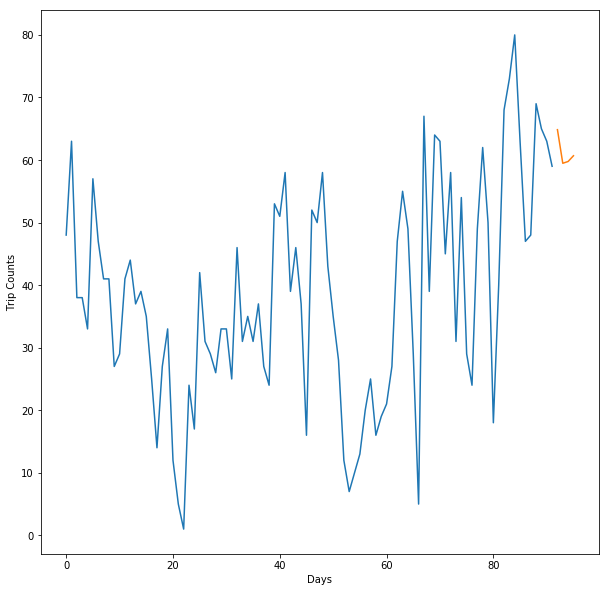

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

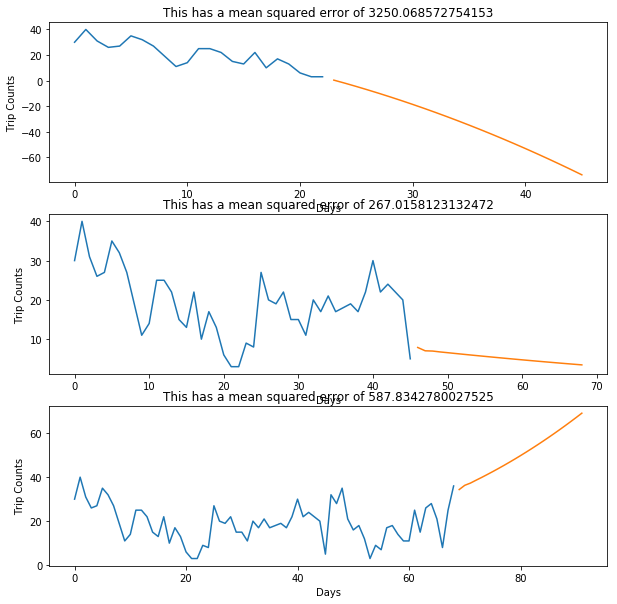

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

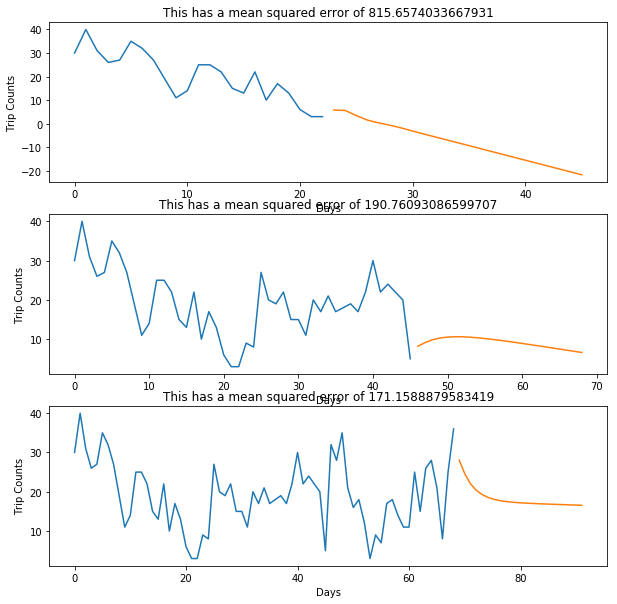

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

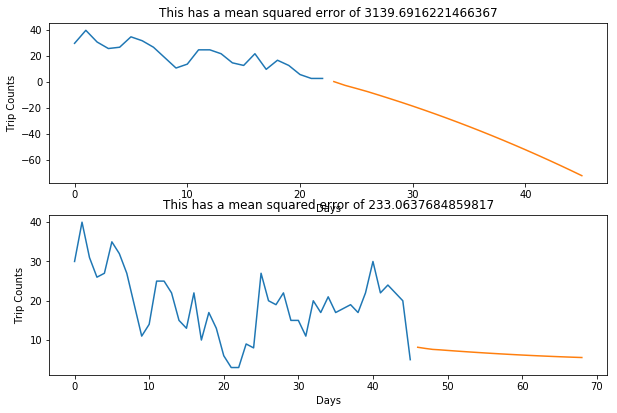

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

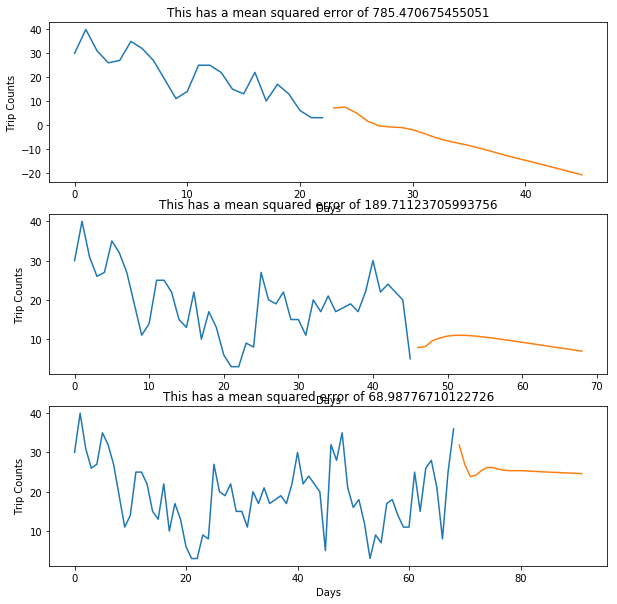

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

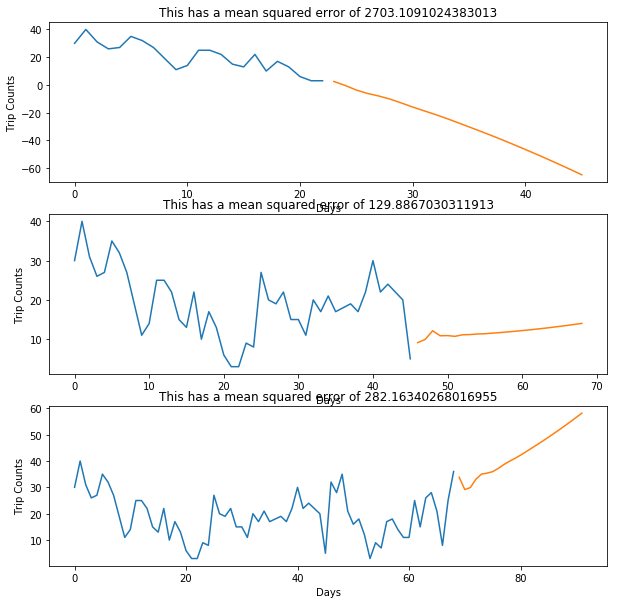

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

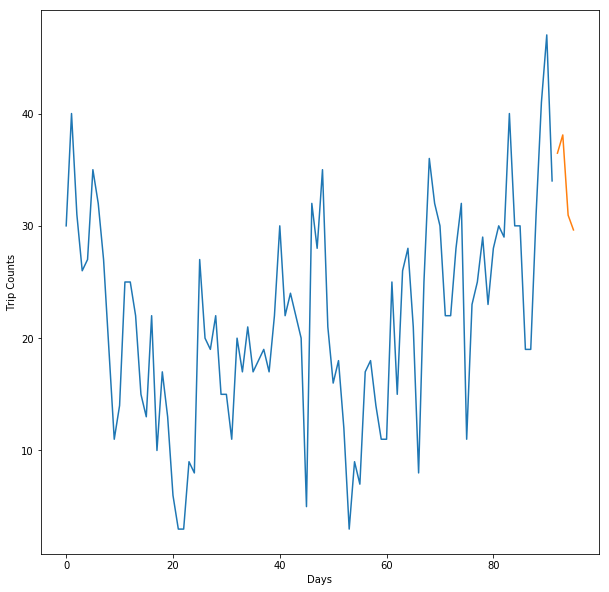

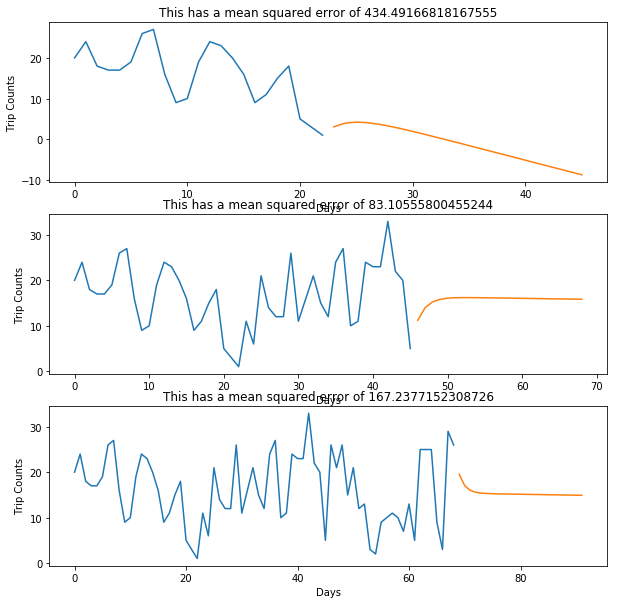

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

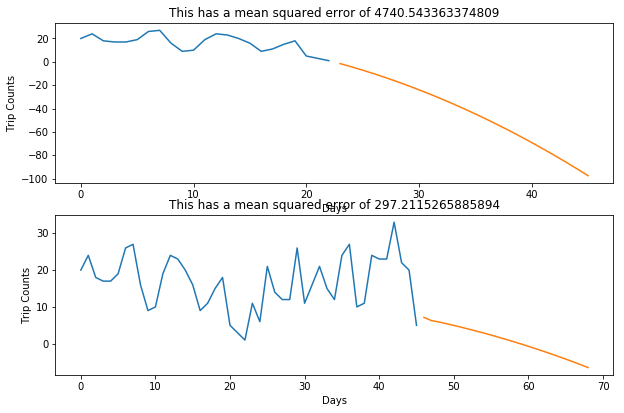

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

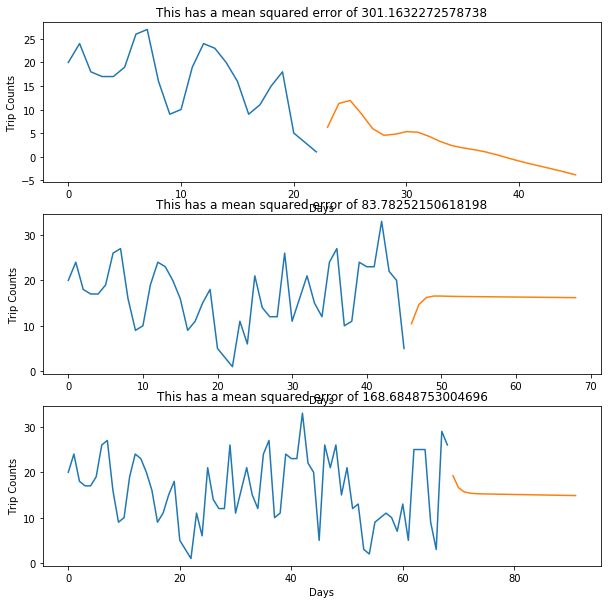

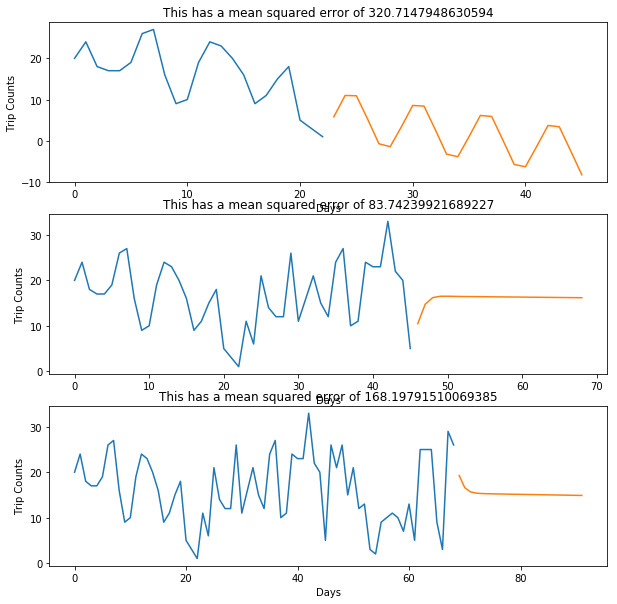

<Figure size 720x720 with 0 Axes>

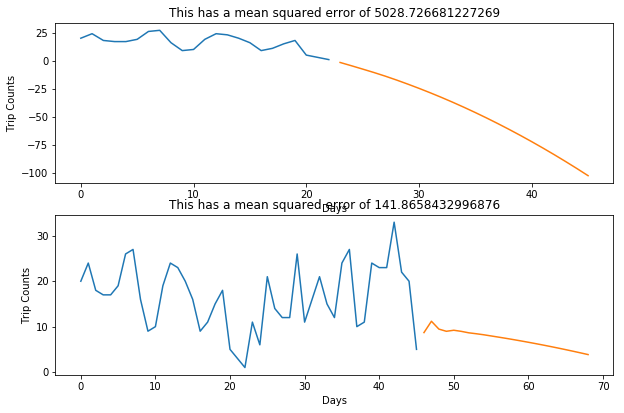

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

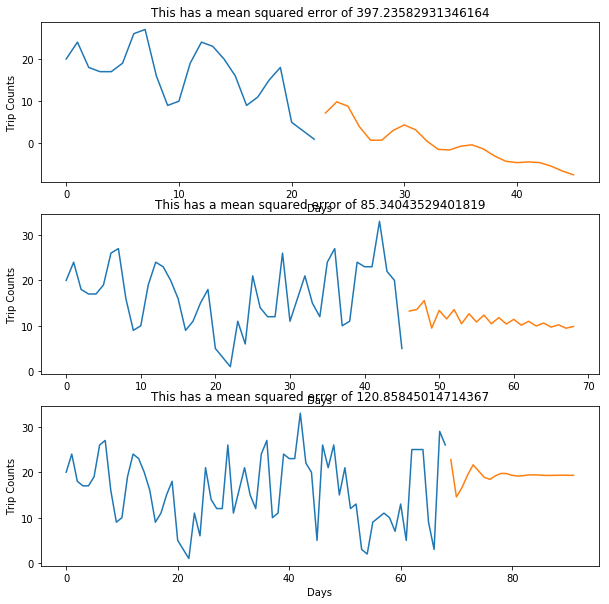

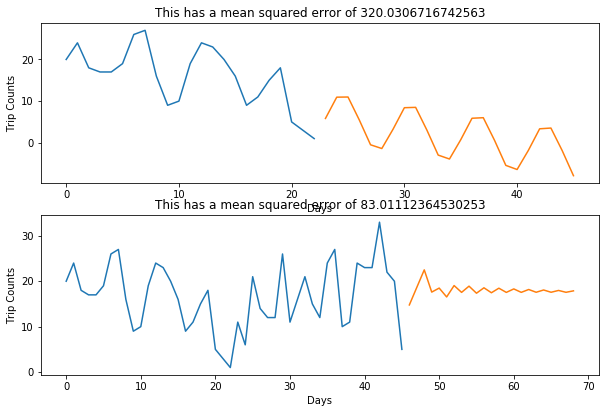

<Figure size 720x720 with 0 Axes>

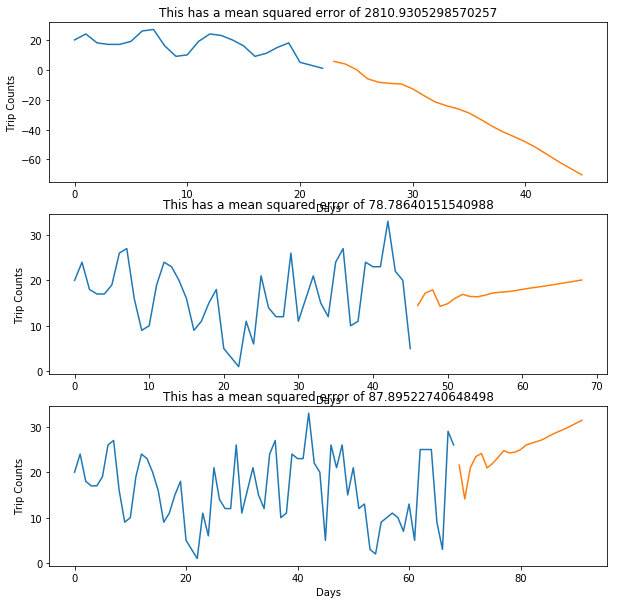

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

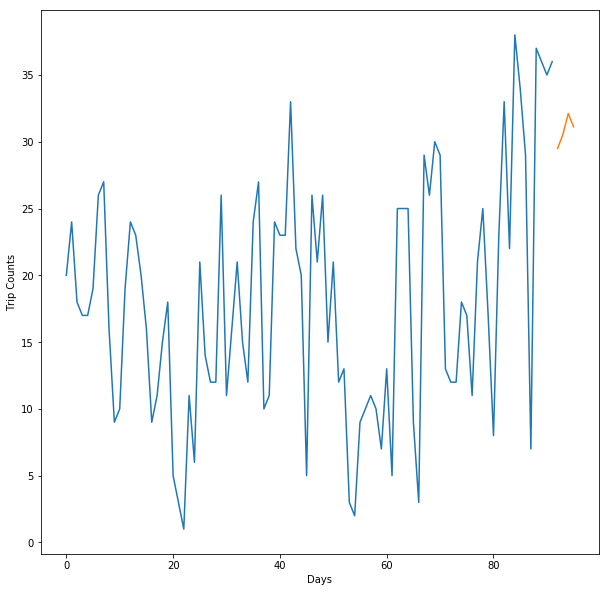

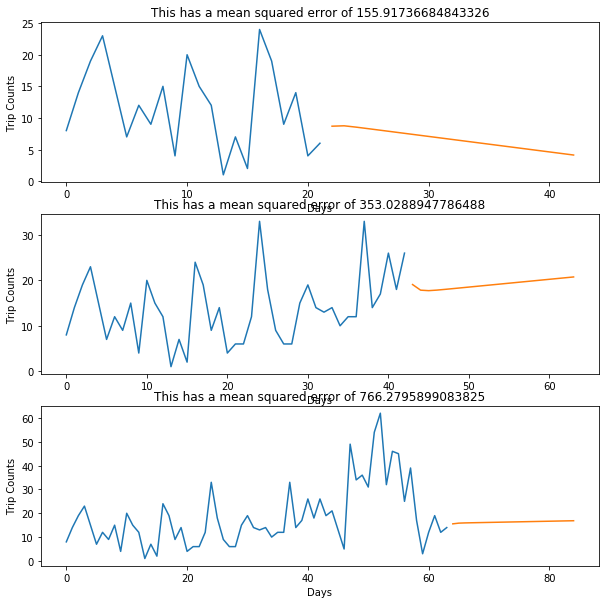

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

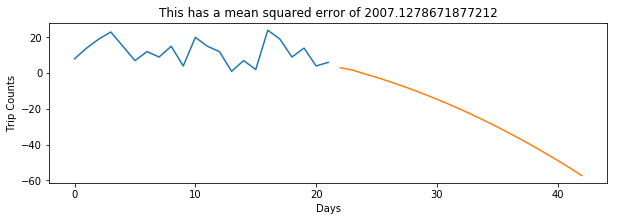

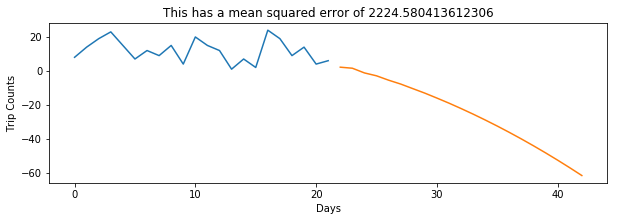

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

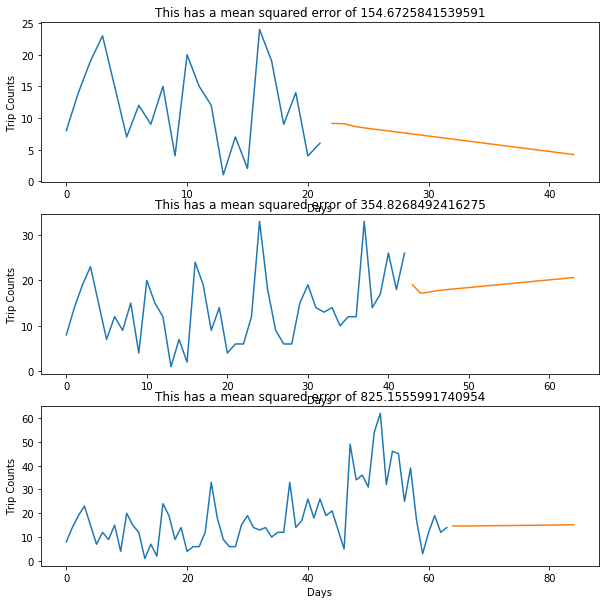

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

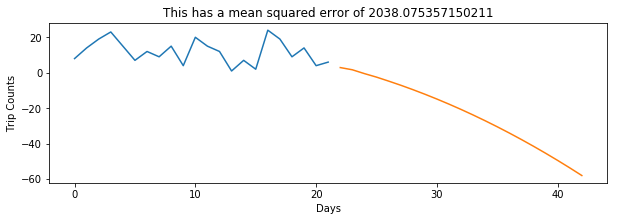

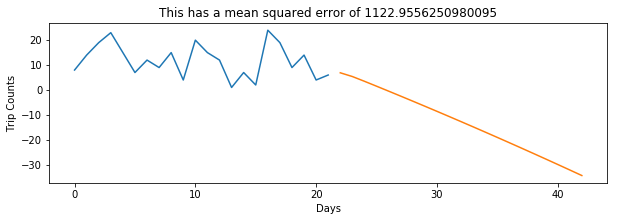

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

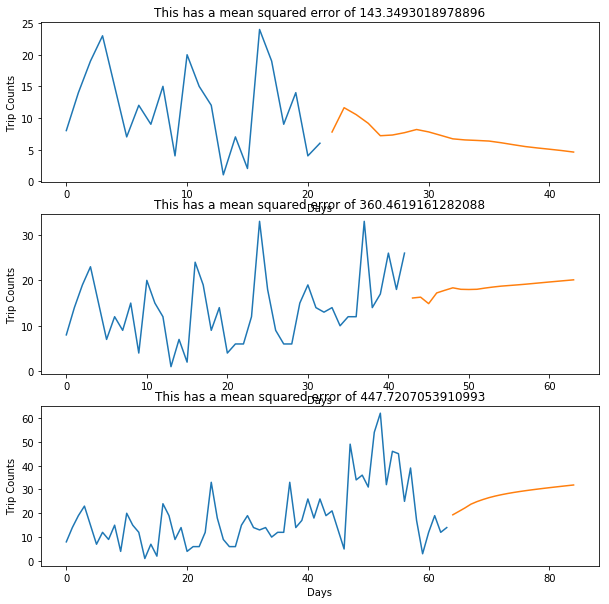

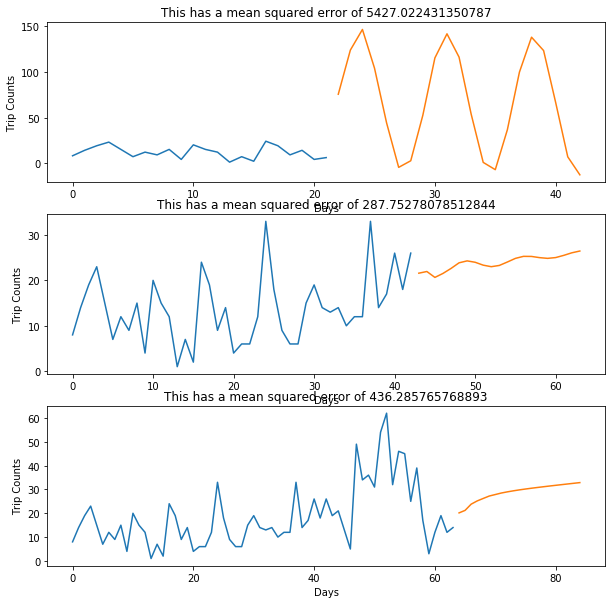

<Figure size 720x720 with 0 Axes>

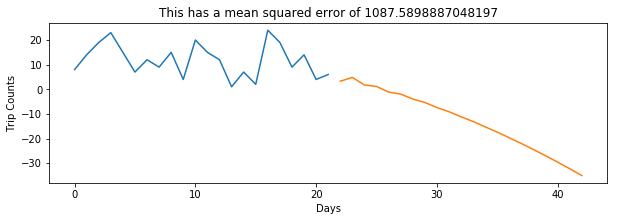

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

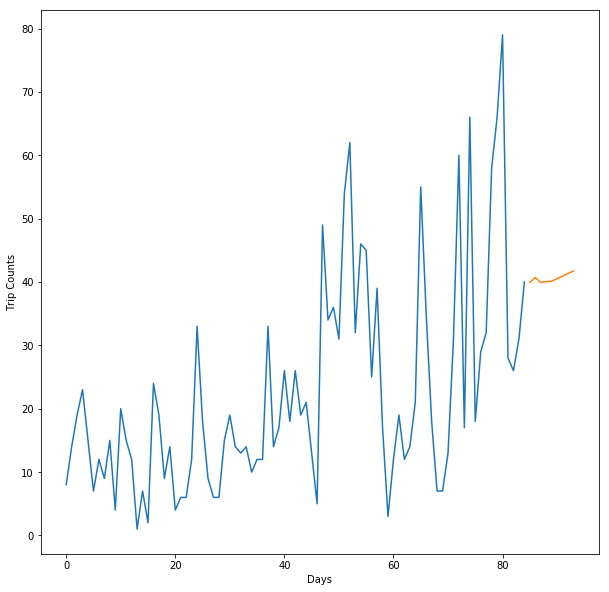

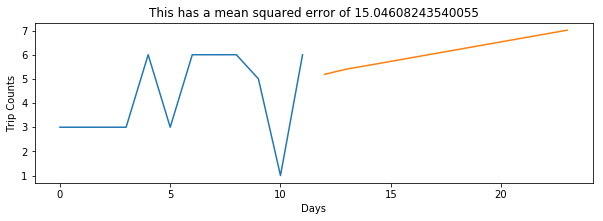

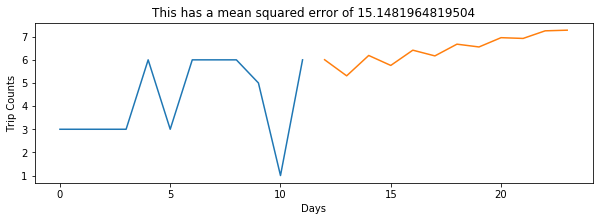

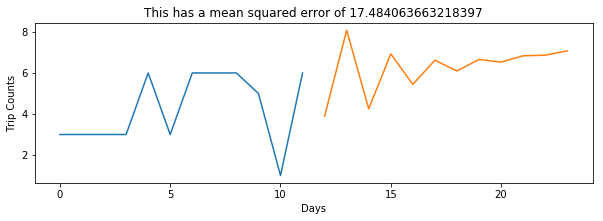

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

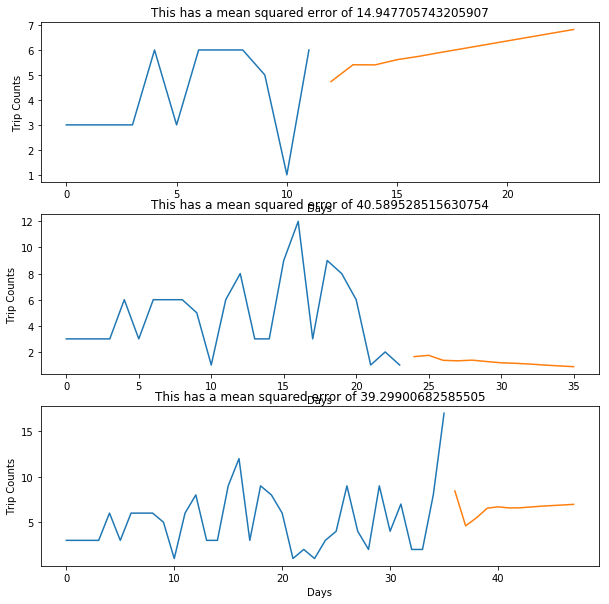

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

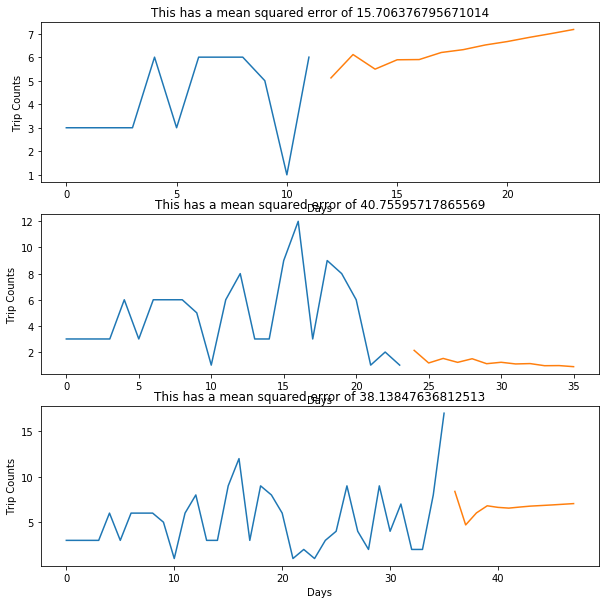

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

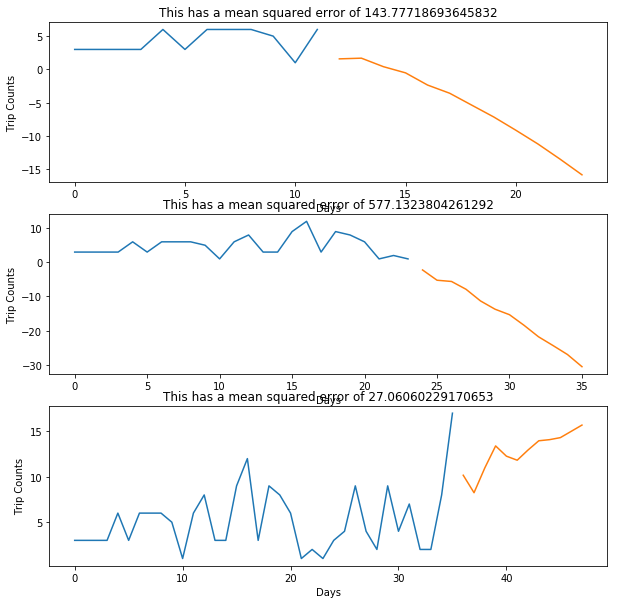

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

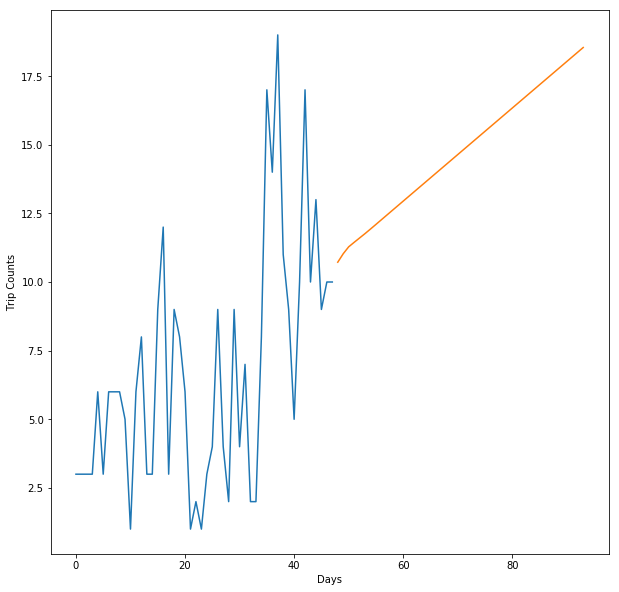

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

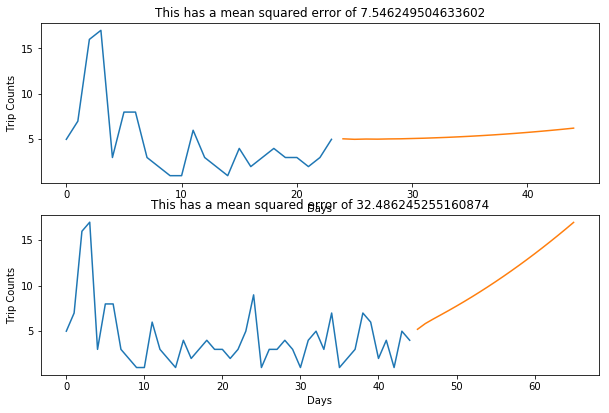

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

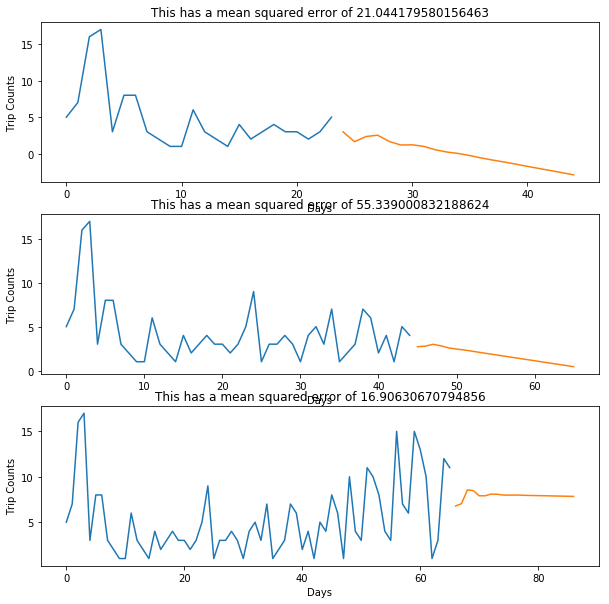

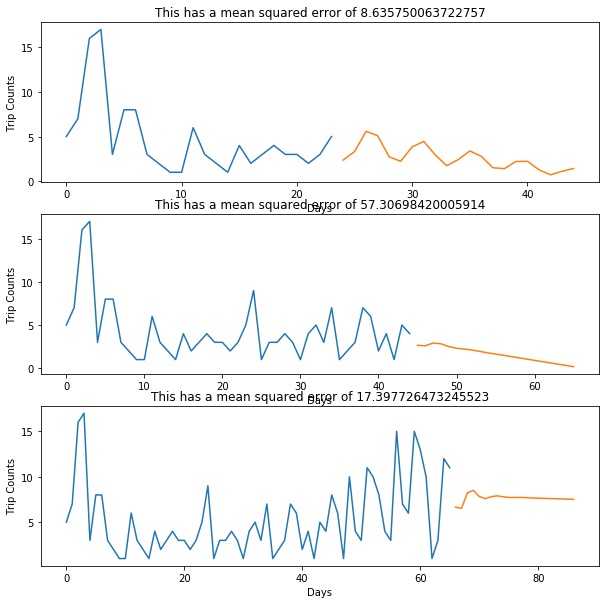

<Figure size 720x720 with 0 Axes>

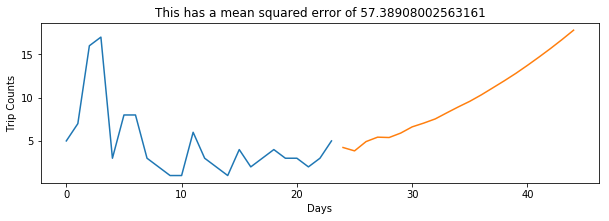

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

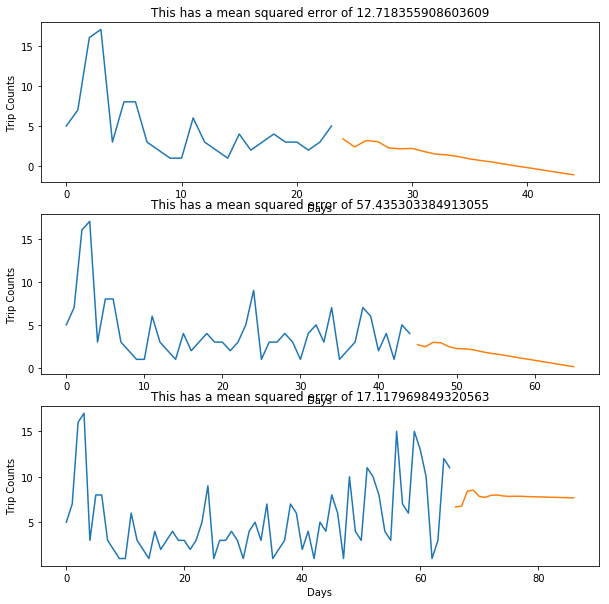

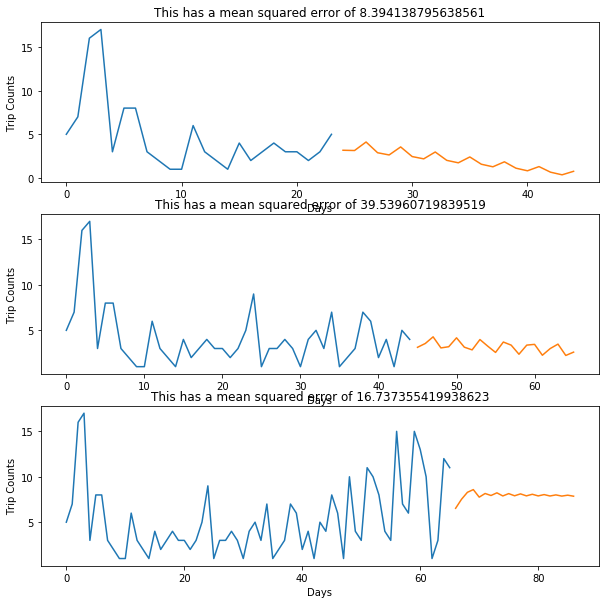

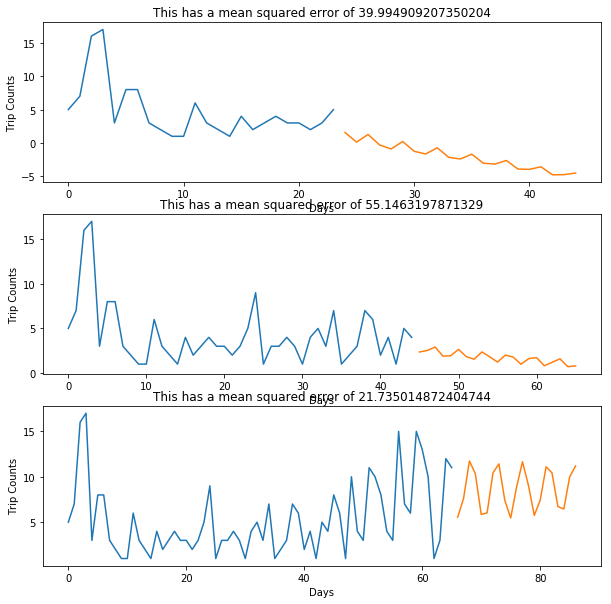

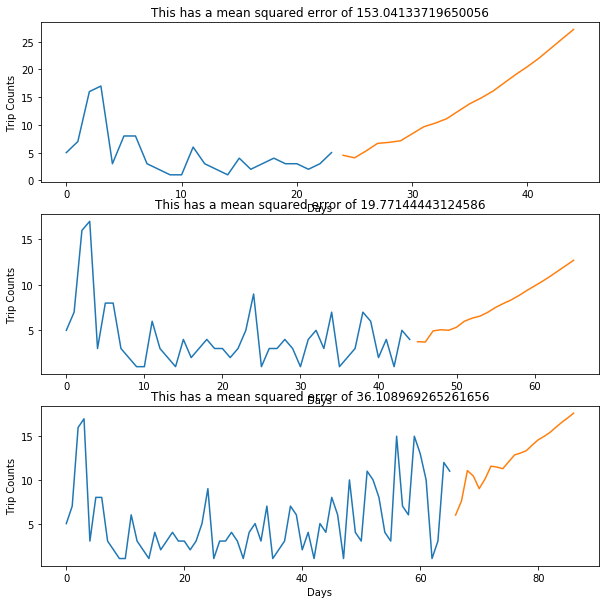

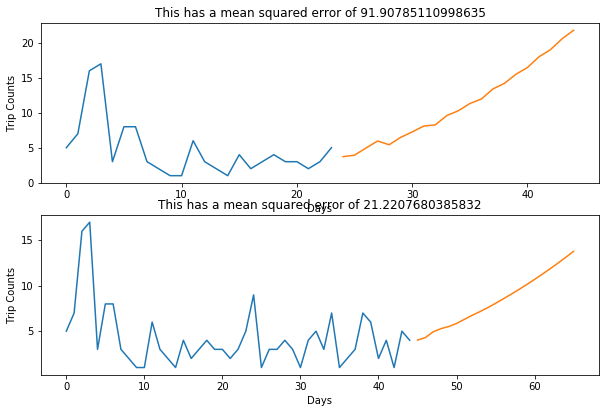

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

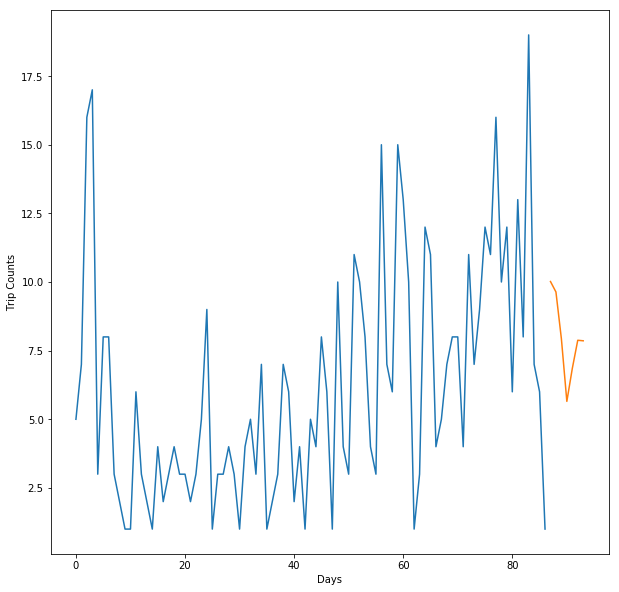

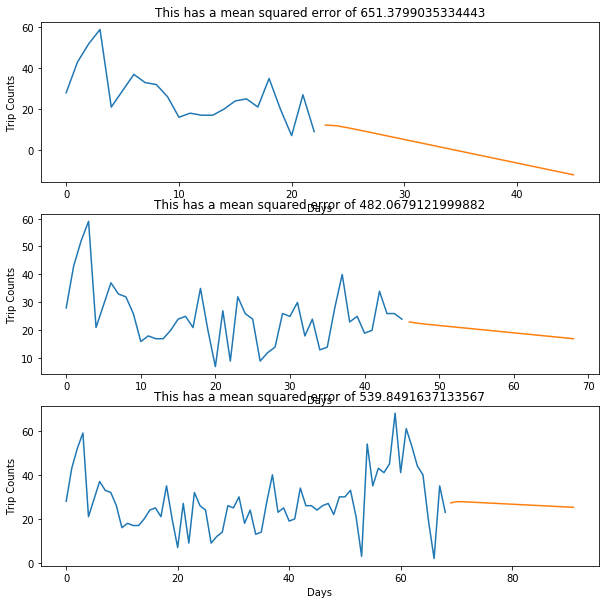

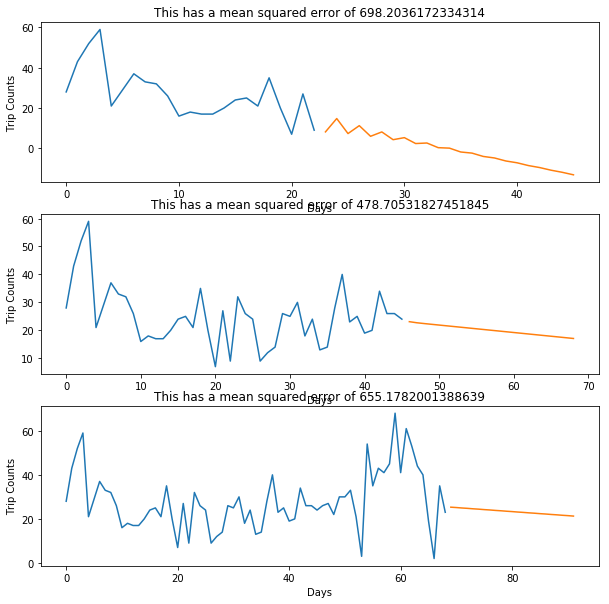

<Figure size 720x720 with 0 Axes>

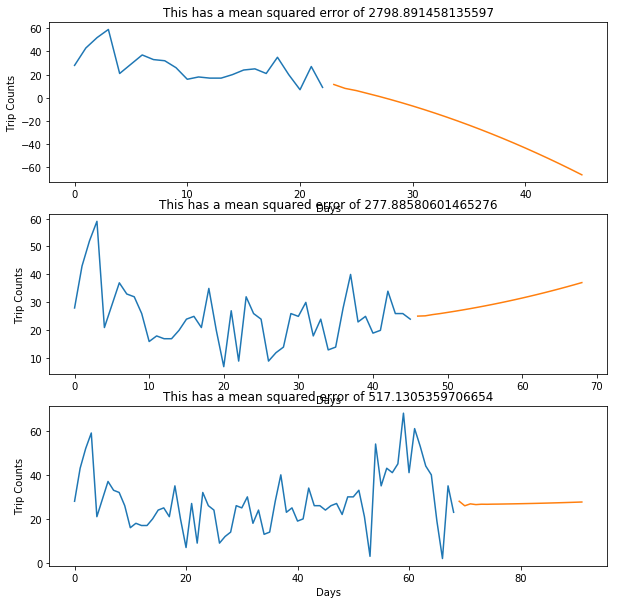

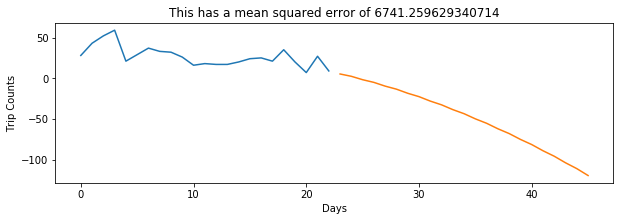

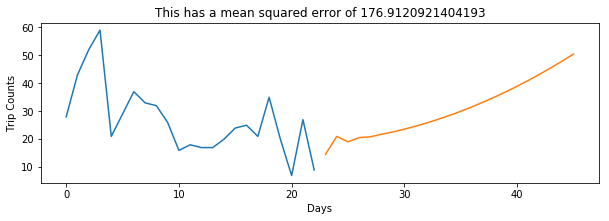

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

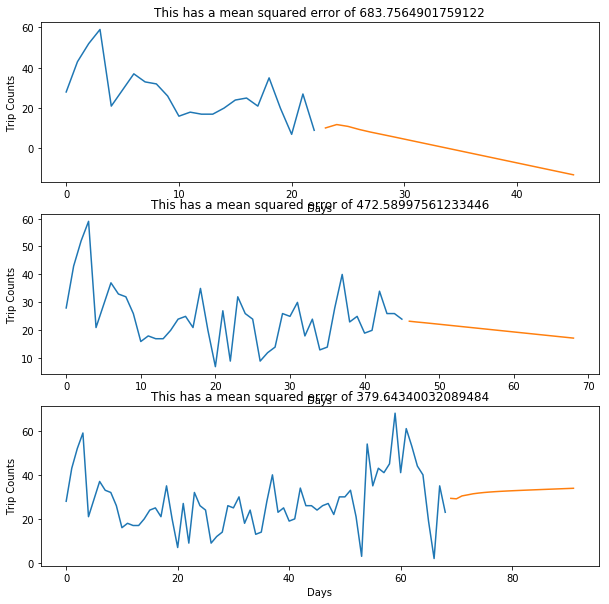

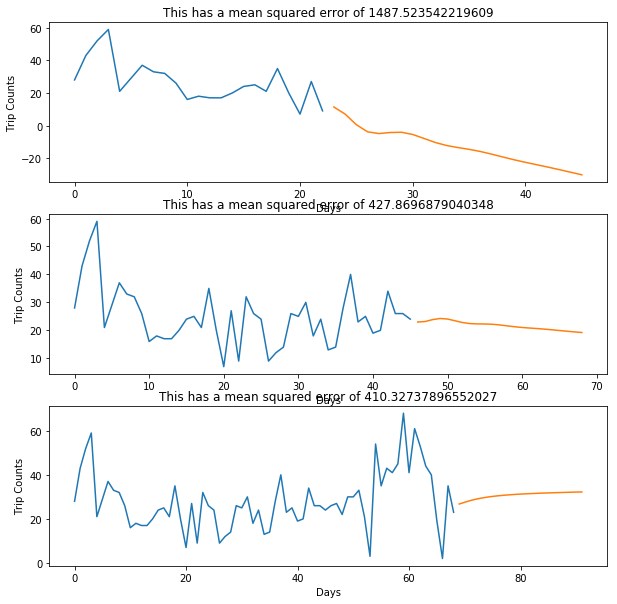

<Figure size 720x720 with 0 Axes>

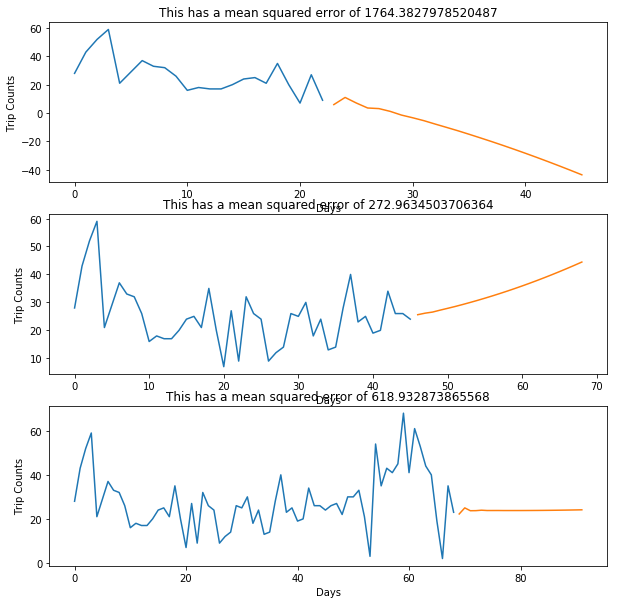

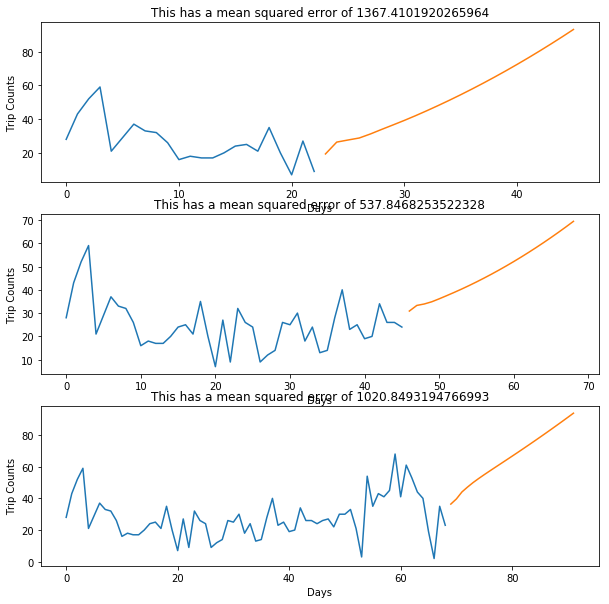

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

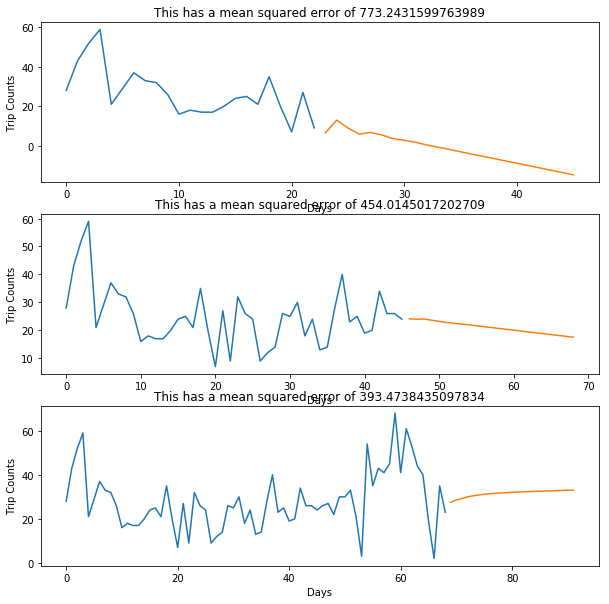

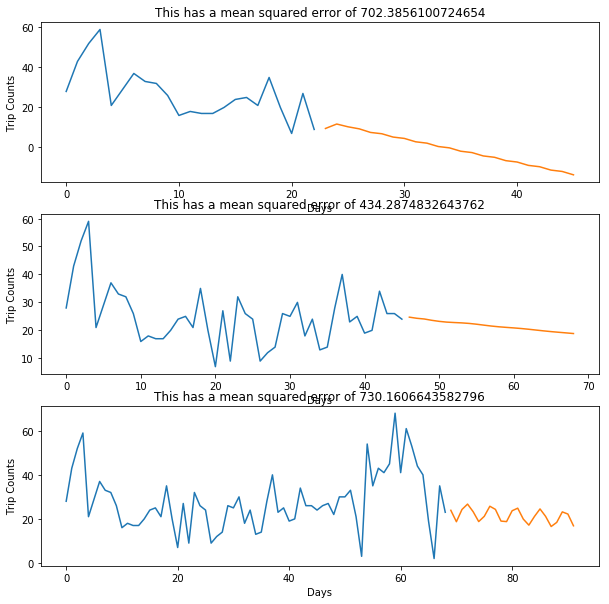

<Figure size 720x720 with 0 Axes>

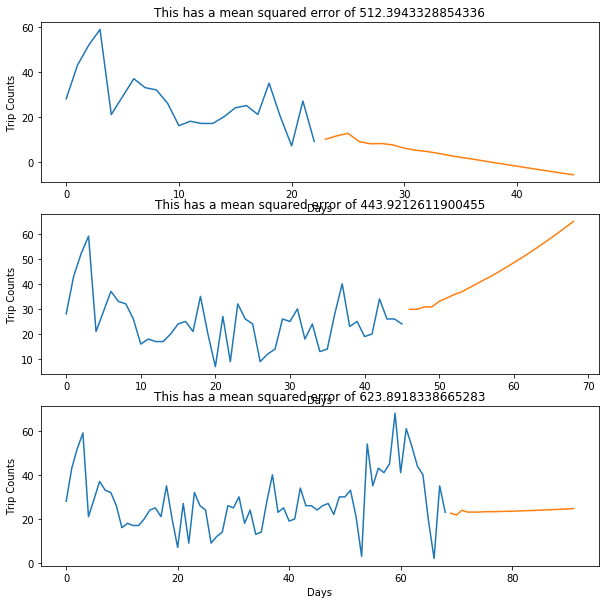

<Figure size 720x720 with 0 Axes>

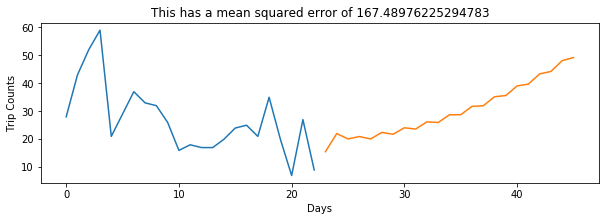

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

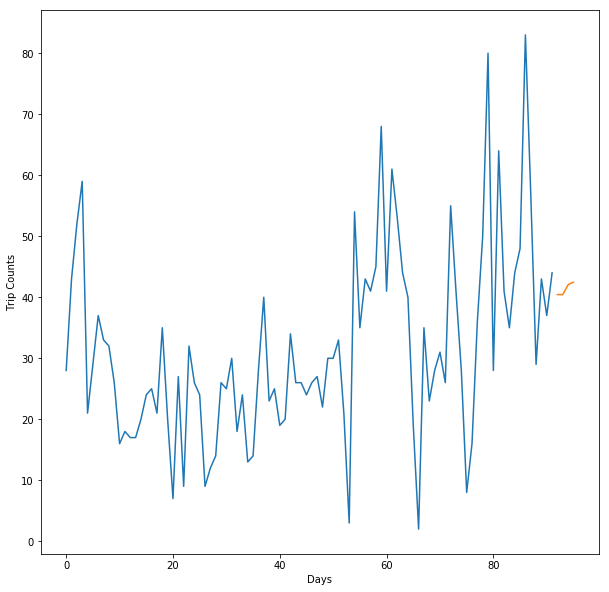

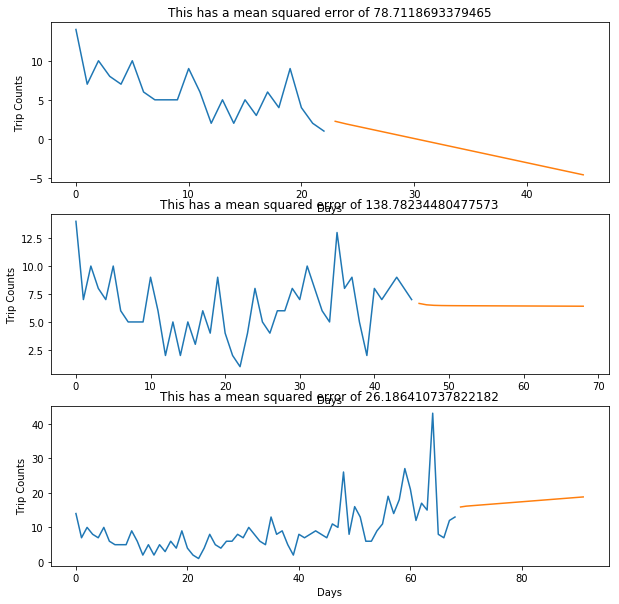

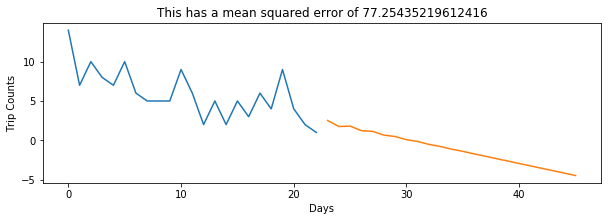

<Figure size 720x720 with 0 Axes>

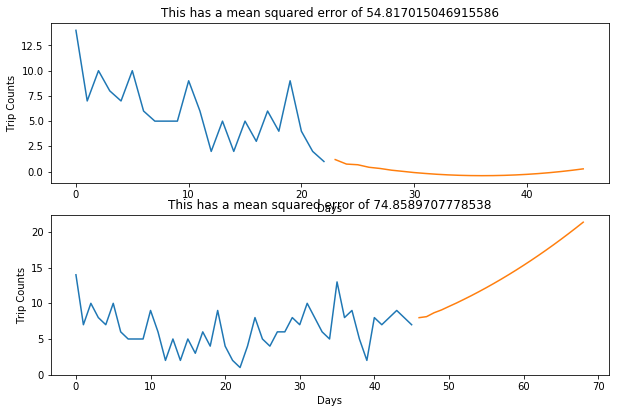

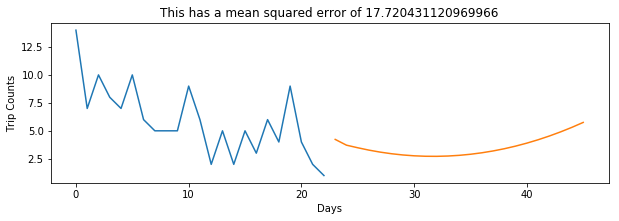

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

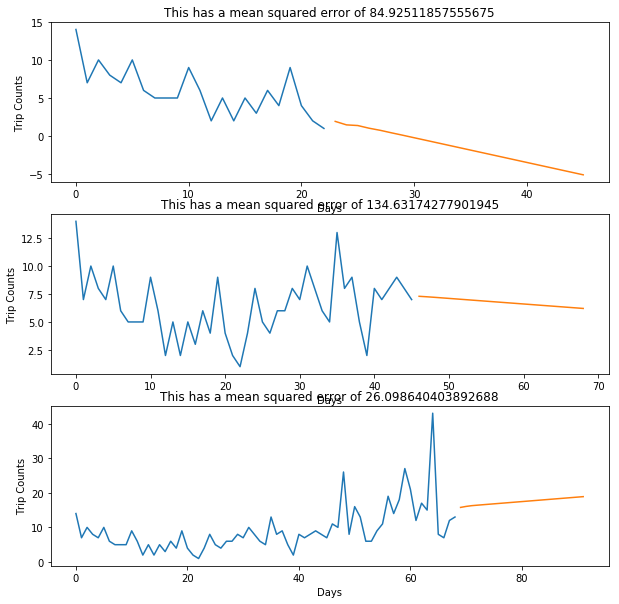

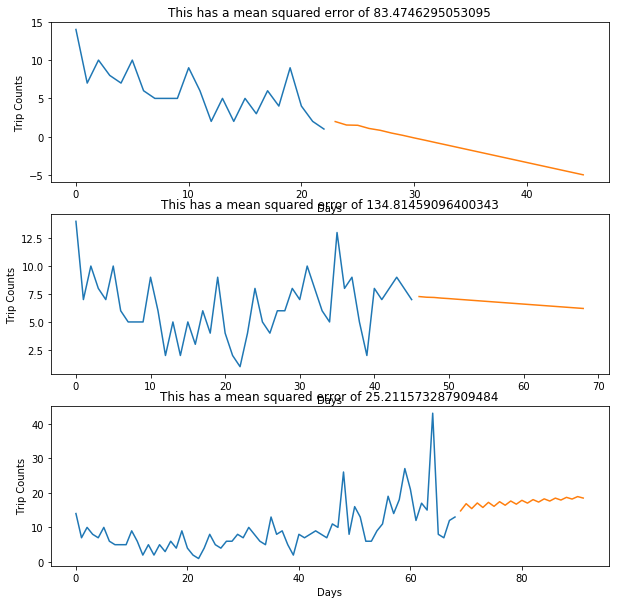

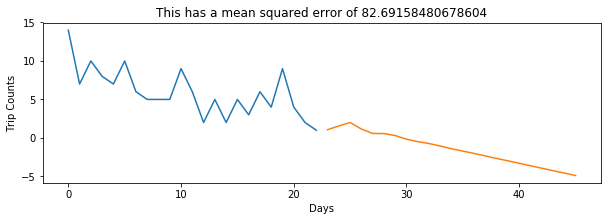

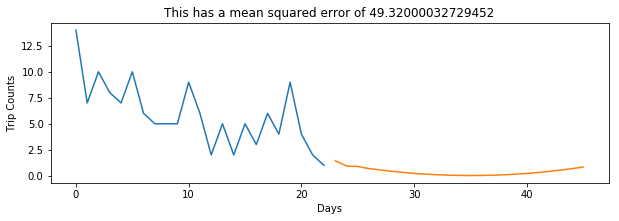

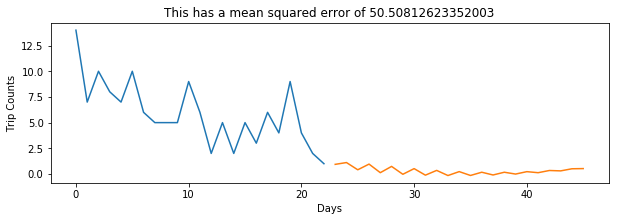

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

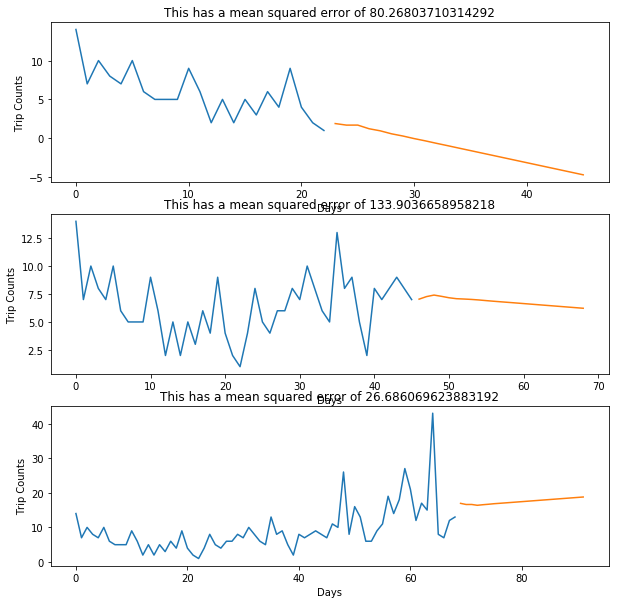

<Figure size 720x720 with 0 Axes>

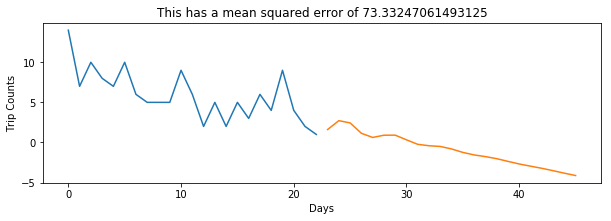

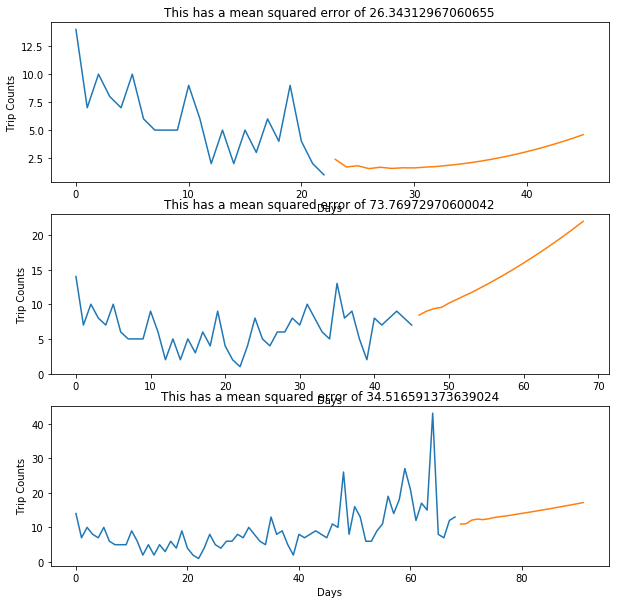

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

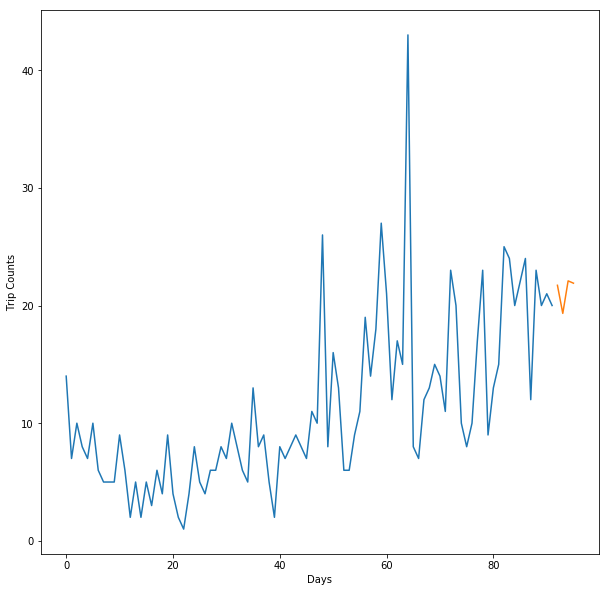

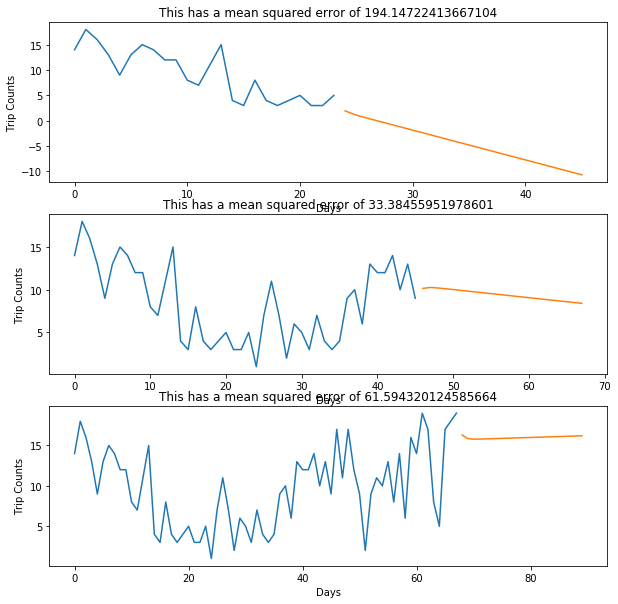

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

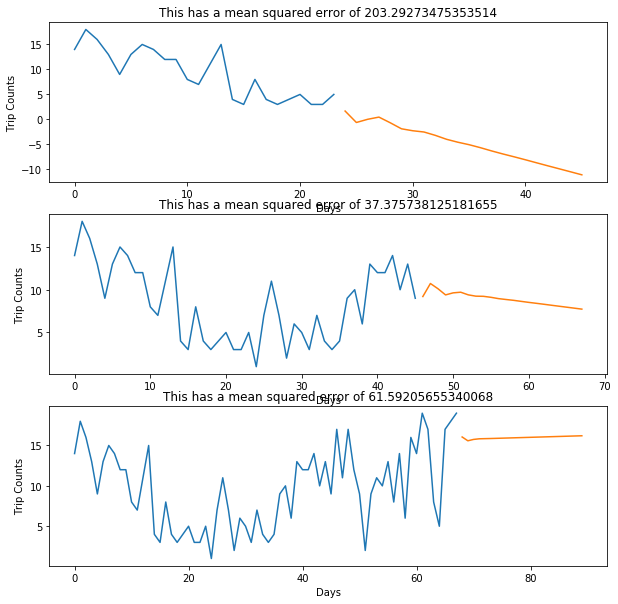

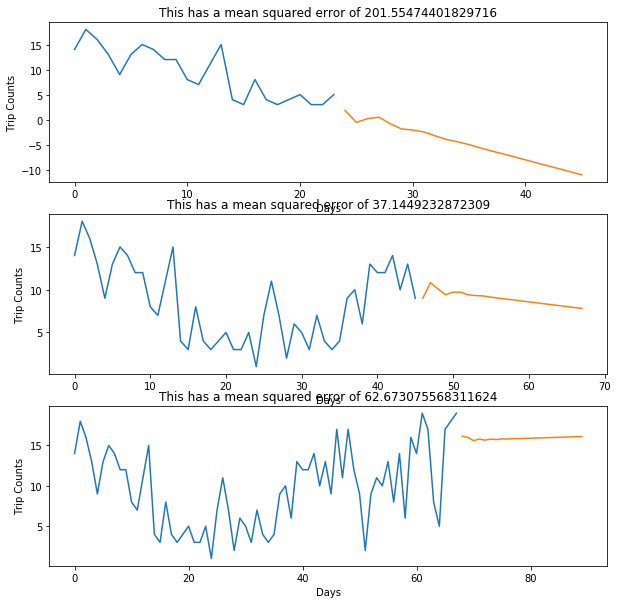

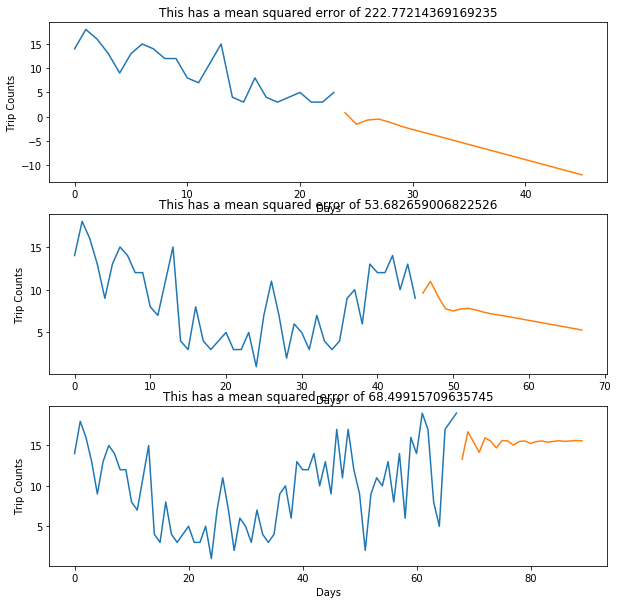

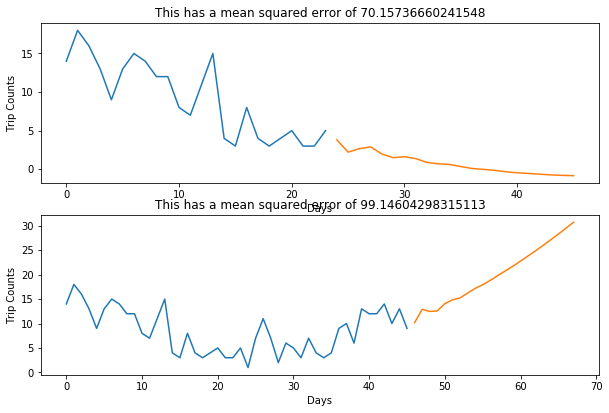

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

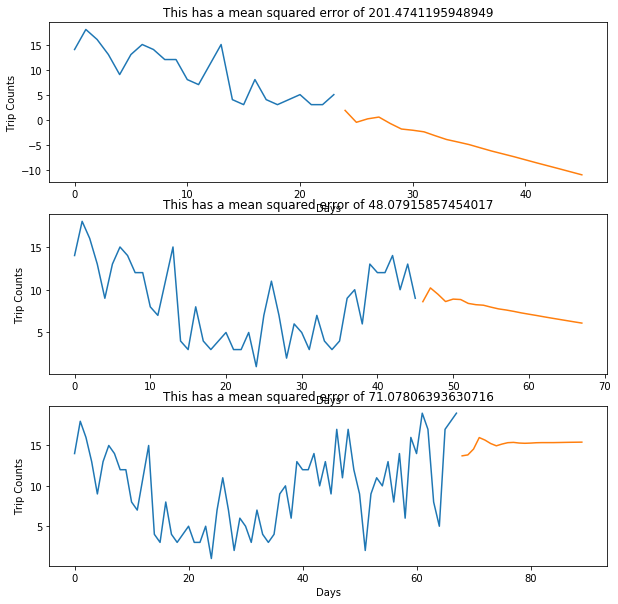

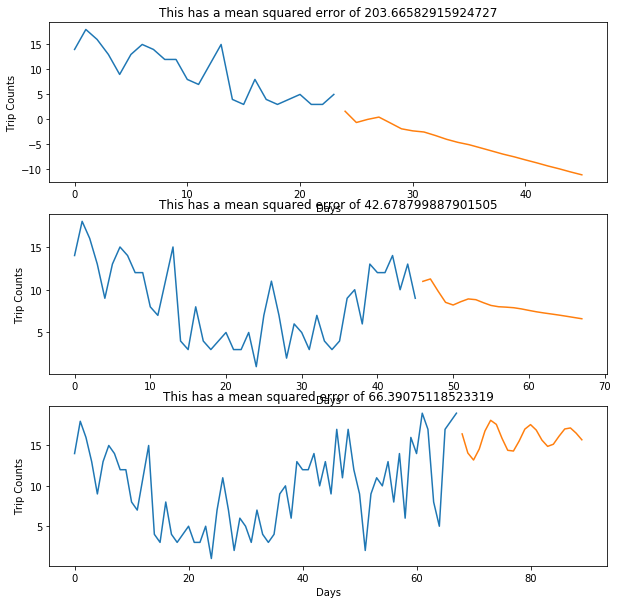

<Figure size 720x720 with 0 Axes>

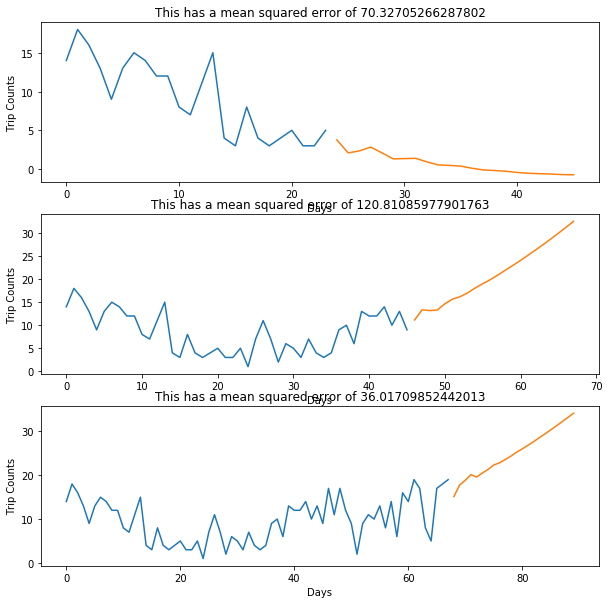

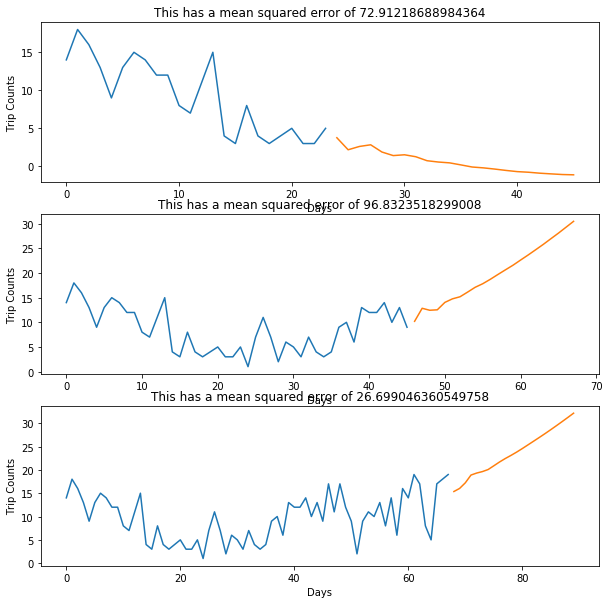

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [57]:
trend = ready_set_go(sub,cdf, neighbors)

In [58]:
trend

{344: array([33.55, 23.12, 26.07]),
 386: array([61.2 , 33.79, 30.82]),
 51: array([40.59, 14.72,  7.97]),
 398: array([41.35, 21.26])}

In [62]:
neighbors

{344: [345, 116, 115],
 386: [134, 133, 141],
 51: [377, 380, 375],
 398: [371, 369, 370]}

In [68]:
np.array(sub.days[sub.end_station_id == 345].value_counts()).mean()

18.108695652173914

In [85]:
def baseline(neighbors, sub):
    avg_count = {}
    for k, v in neighbors.items():
        avg_lst = []
        for s_id in v:
            avg = np.array(sub.days[sub.end_station_id == s_id].value_counts()).mean()
            avg_lst.append(avg)
        avg = np.round(np.array(avg_lst).mean(),decimals=3)
        avg_count[k] = avg
    return avg_count

In [86]:
baseline(neighbors,sub)

{344: 16.732, 386: 25.895, 51: 11.817, 398: 18.45}

In [87]:
def validate(sub, neighbors, trend, ndf):
    
    base = baseline(neighbors,sub)
    #validate the stations in the trend dictionary
    for k, v in trend.items():
        
        #mean of forecasted values
        neighbor_mean = v.mean()
        
        #using the following month's data to calculate actual trips per day
        count = ndf[ndf.end_station_id == test_station]["day"].value_counts()
        actual_trips_per_day = np.round(np.array(count).mean(), decimals = 3)
        
        #calc baseline estimate
        
        
        
        
        
        print ("Validating for station {}".format(k))
        print ("The baseline estimate using the mean for neighboring station is {}".format(base.get(k)))
        print ("The average predicted trip count per day is {}.".format(neighbor_mean)) 
        print ("The actual trips per day for the following month is {}.".format(actual_trips_per_day))
        print ("----------------------------")


In [88]:
validate(sub, neighbors, trend, ndf)

Validating for station 344
The baseline estimate using the mean for neighboring station is 16.732
The average predicted trip count per day is 27.580000000000002.
The actual trips per day for the following month is 23.036.
----------------------------
Validating for station 386
The baseline estimate using the mean for neighboring station is 25.895
The average predicted trip count per day is 41.93666666666667.
The actual trips per day for the following month is 23.036.
----------------------------
Validating for station 51
The baseline estimate using the mean for neighboring station is 11.817
The average predicted trip count per day is 21.093333333333334.
The actual trips per day for the following month is 23.036.
----------------------------
Validating for station 398
The baseline estimate using the mean for neighboring station is 18.45
The average predicted trip count per day is 31.305.
The actual trips per day for the following month is 23.036.
----------------------------
